In [ ]:
# Import niezbędnych bibliotek
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from itertools import product
from prettytable import PrettyTable
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.metrics import mean_squared_error

In [ ]:
# Lista hiperparametrów do eksperymentów
hidden_size_list = [32, 64]  # liczba neuronów
num_layers_list = [1, 3]  # Liczba warstw GRU
dropout_list = [0.1, 0.2]  # Dropout
learning_rate_list = [0.001, 0.0001]  # Learning rate
sequence_lengths = [30, 100, 150] # Długość szeregu czasowego używanego w procesie nauki

# Kombinacje wszystkich hiperparametrów
param_combinations = list(product(sequence_lengths, hidden_size_list, num_layers_list, dropout_list, learning_rate_list))

In [ ]:
# Wczytanie danych z pliku CSV
data = pd.read_excel('Open-Open-Dataset-BTC.xlsx')

data.head()

,Date,LogReturn,Open,High,Low,Close,Volume,MarketCap,FearAndGreed,VDD,...,GoldClose,DaysSinceHalving,S&P500,M2SL,InflationUSA,DXY,VIX of VIX,HashRate,MA5,MA20
0,2024-12-31,0.00840,92643.25122,96090.60379,91914.02778,93429.20281,4.362511e+10,1.850180e+12,66,0.67190,...,2624.585,255,5881.63,21447.6,2.3,108.49,104.33,"703 991 000 000 000 000 000,00",93786.28763,98469.55779
1,2024-12-30,-0.00950,93527.19750,94903.32390,91317.13546,92643.21460,5.618800e+10,1.834640e+12,64,0.66965,...,2605.965,254,5906.94,21447.6,2.3,108.13,103.05,"867 710 000 000 000 000 000,00",94259.55038,98918.49559
2,2024-12-29,-0.01746,95174.05512,95174.87840,92881.79187,93530.22844,2.963589e+10,1.852120e+12,65,0.66739,...,2615.555,253,5970.84,21447.6,2.3,108.00,98.81,"852 361 000 000 000 000 000,00",95590.74601,99084.03270
3,2024-12-28,0.01071,94160.18622,95525.89852,94014.28650,95163.93193,2.410744e+10,1.884680e+12,73,0.66507,...,2615.555,252,5970.84,21447.6,2.3,108.00,98.81,"771 441 000 000 000 000 000,00",96619.91980,99203.44266
4,2024-12-27,-0.01627,95704.97459,97294.84642,93310.74380,94164.86035,5.241993e+10,1.864540e+12,72,0.66349,...,2615.555,251,5970.84,21447.6,2.3,108.00,98.81,"852 361 000 000 000 000 000,00",96524.38131,99575.60860


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4921 entries, 0 to 4920
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              4921 non-null   datetime64[ns]
 1   LogReturn         4921 non-null   float64       
 2   Open              4921 non-null   float64       
 3   High              4921 non-null   float64       
 4   Low               4921 non-null   float64       
 5   Close             4921 non-null   float64       
 6   Volume            4921 non-null   float64       
 7   MarketCap         4921 non-null   float64       
 8   FearAndGreed      4921 non-null   int64         
 9   VDD               4921 non-null   float64       
 10  CBBI              4921 non-null   float64       
 11  GoldClose         4921 non-null   float64       
 12  DaysSinceHalving  4921 non-null   int64         
 13  S&P500            4921 non-null   float64       
 14  M2SL              4921 n

In [ ]:
# Funkcja czyszcząca dane - usuwa niepotrzebne znaki
def clean_and_convert_to_numeric(df):
    return df.applymap(
        lambda x: float(str(x).replace(',', '.').replace('\xa0', '').strip())
        if isinstance(x, str) else x
    )

# Czyszczenie danych i usunięcie zbędnych kolumn
data_cleaned = clean_and_convert_to_numeric(data.drop(columns=['Date', 'Close'], errors='ignore'))

# Podział na cechy (X) i cel (y)
X = data_cleaned.drop(columns=['LogReturn'], errors='ignore').values
y = data_cleaned['LogReturn'].values

# Skalowanie danych wejściowych i celu
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Podział danych na zbiory treningowy, walidacyjny i testowy
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

<ipython-input-6-1a1ea2ec797e>:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(


In [ ]:
print(np.isnan(X_train).sum(), np.isnan(y_train).sum())
print(np.isinf(X_train).sum(), np.isinf(y_train).sum())

0 0
0 0


In [ ]:
# Klasa do tworzenia zbiorów sekwencyjnych
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, sequence_length):
        self.X, self.y = self.create_sequences(X, y, sequence_length)

    def create_sequences(self, X, y, sequence_length):
        X_seq, y_seq = [], []
        for i in range(len(X) - sequence_length):
            X_seq.append(X[i:i + sequence_length])
            y_seq.append(y[i + sequence_length])
        return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

#Tworzenie modelu GRU


Definiujemy funkcję `initialize_model`, która pozwala łatwo inicjalizować model GRU z różnymi parametrami (`hidden_size`, `num_layers`, `dropout`). Klasa `GRUModel` składa się z modułu GRU do przetwarzania danych sekwencyjnych i warstwy liniowej do przewidywania wartości docelowej. Model wykorzystuje ostatnie wyjście GRU jako wejście do warstwy liniowej. Pozwala to eksperymentować z konfiguracjami sieci, aby dopasować je do danych i zadania. Na końcu inicjalizujemy model z domyślnymi parametrami (`hidden_size=50`, `num_layers=2`, `dropout=0.2`).

In [ ]:
# Funkcja do inicjalizacji modelu z różnymi parametrami
def initialize_model(input_size, hidden_size, num_layers, dropout):
    return GRUModel(input_size, hidden_size, num_layers, output_size=1, dropout=dropout)

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = X_train.shape[1]


Do obliczenia funkcji straty używamy HuberLoss ponieważ jest on lepszy od MSE dla małych błędów (nasze logarytmy stopy zwrotu mają małe wartości), a także jest przydatny gdy dane mają outliery. HubertLoss łączy zalety MSE i MAE.

Funkcja train_model_with_early_stopping trenuje model z mechanizmem wczesnego zatrzymania, który przerywa trening, gdy strata walidacyjna nie poprawia się przez określoną liczbę epok (patience). Rejestruje straty treningowe i walidacyjne w każdej epoce oraz zapisuje najlepszy model na podstawie najniższej straty walidacyjnej. Na końcu zwraca model oraz listy strat do wizualizacji.

In [ ]:
# Funkcja kosztu i optymalizator
criterion = nn.HuberLoss(delta=0.1)

def train_model_with_early_stopping(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=5
):
    """
    Funkcja trenowania modelu z mechanizmem wczesnego zatrzymania i rejestracją strat.
    """
    best_val_loss = float('inf')
    epochs_no_improve = 0

    train_losses = []  # Lista strat treningowych
    val_losses = []    # Lista strat walidacyjnych

    for epoch in range(num_epochs):
        # Trening
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Walidacja
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            # Zapis najlepszego modelu
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break

    # Wczytanie najlepszego modelu
    model.load_state_dict(torch.load('best_model.pth'))

    # Zwrócenie modelu i strat do wizualizacji
    return model, train_losses, val_losses

Trenowanie modelu GRU z wykorzystaniem wczesnego zatrzymania w sytuacji gdy wyniki się nie poprawiają oraz testując różne kombinacje hiperparametrów.

In [ ]:
# Funkcja treningu z wczesnym zatrzymaniem i eksperymentami
def train_and_evaluate(param_combination):
    sequence_length, hidden_size, num_layers, dropout, learning_rate = param_combination

    # Tworzenie zbiorów danych i DataLoaderów dla danej długości sekwencji
    train_dataset = TimeSeriesDataset(X_train, y_train, sequence_length)
    val_dataset = TimeSeriesDataset(X_val, y_val, sequence_length)
    test_dataset = TimeSeriesDataset(X_test, y_test, sequence_length)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64)
    test_loader = DataLoader(test_dataset, batch_size=64)

    # Inicjalizacja modelu
    model = GRUModel(input_size, hidden_size, num_layers, output_size=1, dropout=dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Trenowanie modelu
    trained_model, train_losses, val_losses = train_model_with_early_stopping(
        model, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=5
    )

    # Zwrócenie wyników
    return trained_model, train_losses, val_losses, val_losses[-1], test_loader  # Ostatnia strata walidacyjna

Kod iteruje przez kombinacje hiperparametrów, trenuje model dla każdej z nich, zapisuje wyniki i aktualizuje najlepszy model na podstawie najniższej straty walidacyjnej. Dodatkowo wizualizuje przebieg strat treningowych i walidacyjnych.

Testowanie kombinacji 1/48: (30, 32, 1, 0.1, 0.001)


<ipython-input-8-2142629c709c>:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Epoch 1/20, Train Loss: 0.0060, Val Loss: 0.0014
Epoch 2/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 3/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 4/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 9/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 11/20, Train Loss: 0.0010, Val Loss: 0.0013
Epoch 12/20, Train Loss: 0.0010, Val Loss: 0.0012
Epoch 13/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 14/20, Train Loss: 0.0010, Val Loss: 0.0012
Epoch 15/20, Train Loss: 0.0011, Val Loss: 0.0012
Early stopping triggered at epoch 15


<ipython-input-13-eb25f82cfb70>:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


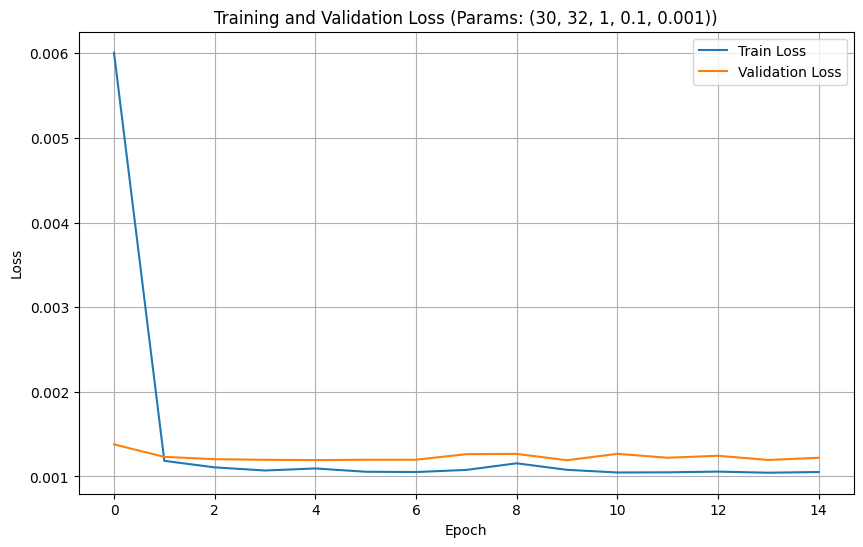

Testowanie kombinacji 2/48: (30, 32, 1, 0.1, 0.0001)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Epoch 1/20, Train Loss: 0.0582, Val Loss: 0.0488
Epoch 2/20, Train Loss: 0.0386, Val Loss: 0.0265
Epoch 3/20, Train Loss: 0.0125, Val Loss: 0.0027
Epoch 4/20, Train Loss: 0.0025, Val Loss: 0.0024
Epoch 5/20, Train Loss: 0.0022, Val Loss: 0.0021
Epoch 6/20, Train Loss: 0.0019, Val Loss: 0.0019
Epoch 7/20, Train Loss: 0.0017, Val Loss: 0.0017
Epoch 8/20, Train Loss: 0.0016, Val Loss: 0.0016
Epoch 9/20, Train Loss: 0.0015, Val Loss: 0.0016
Epoch 10/20, Train Loss: 0.0014, Val Loss: 0.0015
Epoch 11/20, Train Loss: 0.0015, Val Loss: 0.0015
Epoch 12/20, Train Loss: 0.0013, Val Loss: 0.0014
Epoch 13/20, Train Loss: 0.0013, Val Loss: 0.0014
Epoch 14/20, Train Loss: 0.0013, Val Loss: 0.0014
Epoch 15/20, Train Loss: 0.0012, Val Loss: 0.0014
Epoch 16/20, Train Loss: 0.0012, Val Loss: 0.0014
Epoch 17/20, Train Loss: 0.0015, Val Loss: 0.0014
Epoch 18/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 19/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 20/20, Train Loss: 0.0012, Val Loss: 0.0013


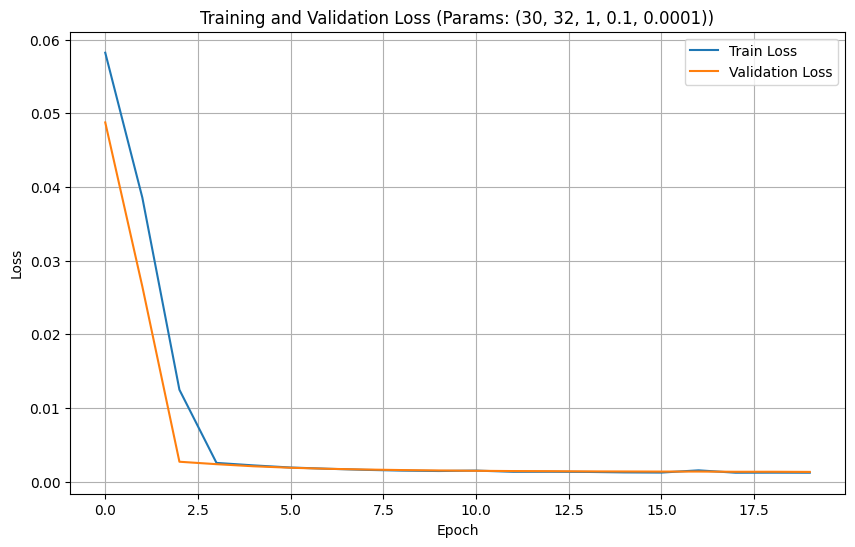

Testowanie kombinacji 3/48: (30, 32, 1, 0.2, 0.001)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/20, Train Loss: 0.0151, Val Loss: 0.0023
Epoch 2/20, Train Loss: 0.0016, Val Loss: 0.0014
Epoch 3/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 4/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0014
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 11/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 12/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 13/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 14/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 15/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 16/20, Train Loss: 0.0011, Val Loss: 0.0015
Epoch 17/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 18/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 19/20, Train Loss: 0.0010, Val Loss: 0.0012
Epoch 20/20, Train Loss: 0.0011, Val Loss: 0.0012


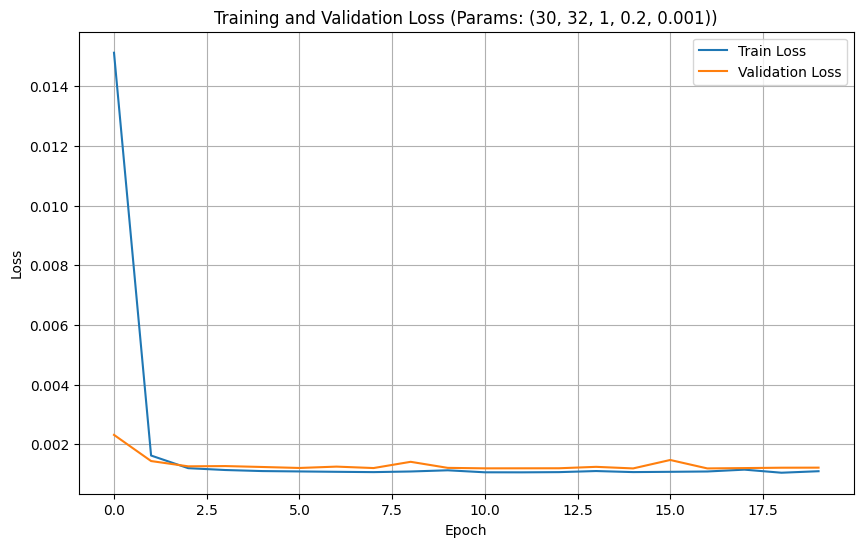

Testowanie kombinacji 4/48: (30, 32, 1, 0.2, 0.0001)
Epoch 1/20, Train Loss: 0.0492, Val Loss: 0.0395
Epoch 2/20, Train Loss: 0.0294, Val Loss: 0.0171
Epoch 3/20, Train Loss: 0.0069, Val Loss: 0.0026
Epoch 4/20, Train Loss: 0.0024, Val Loss: 0.0023
Epoch 5/20, Train Loss: 0.0020, Val Loss: 0.0021
Epoch 6/20, Train Loss: 0.0019, Val Loss: 0.0019
Epoch 7/20, Train Loss: 0.0017, Val Loss: 0.0018
Epoch 8/20, Train Loss: 0.0016, Val Loss: 0.0017
Epoch 9/20, Train Loss: 0.0015, Val Loss: 0.0016
Epoch 10/20, Train Loss: 0.0014, Val Loss: 0.0016
Epoch 11/20, Train Loss: 0.0014, Val Loss: 0.0015
Epoch 12/20, Train Loss: 0.0013, Val Loss: 0.0015
Epoch 13/20, Train Loss: 0.0013, Val Loss: 0.0015
Epoch 14/20, Train Loss: 0.0012, Val Loss: 0.0015
Epoch 15/20, Train Loss: 0.0012, Val Loss: 0.0014
Epoch 16/20, Train Loss: 0.0012, Val Loss: 0.0014
Epoch 17/20, Train Loss: 0.0012, Val Loss: 0.0014
Epoch 18/20, Train Loss: 0.0012, Val Loss: 0.0014
Epoch 19/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 

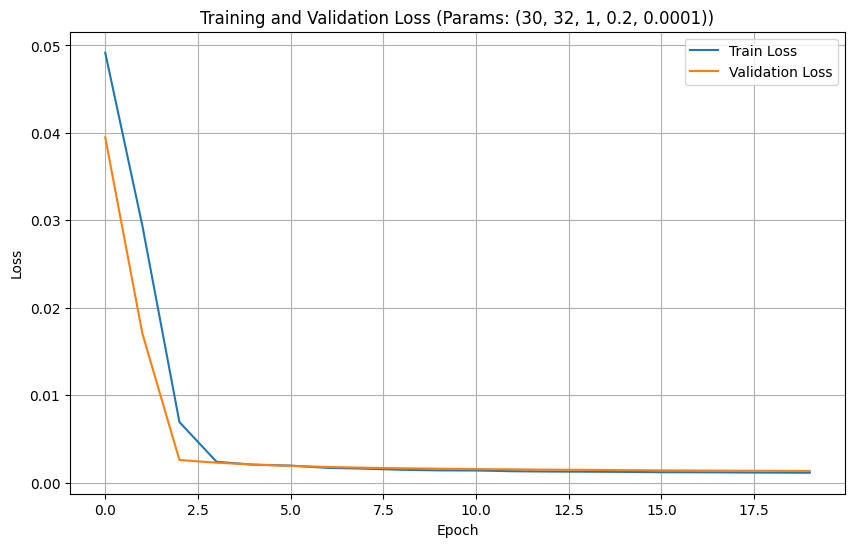

Testowanie kombinacji 5/48: (30, 32, 3, 0.1, 0.001)
Epoch 1/20, Train Loss: 0.0031, Val Loss: 0.0012
Epoch 2/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 3/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 4/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 10/20, Train Loss: 0.0010, Val Loss: 0.0012
Epoch 11/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 12/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 13/20, Train Loss: 0.0011, Val Loss: 0.0012
Early stopping triggered at epoch 13


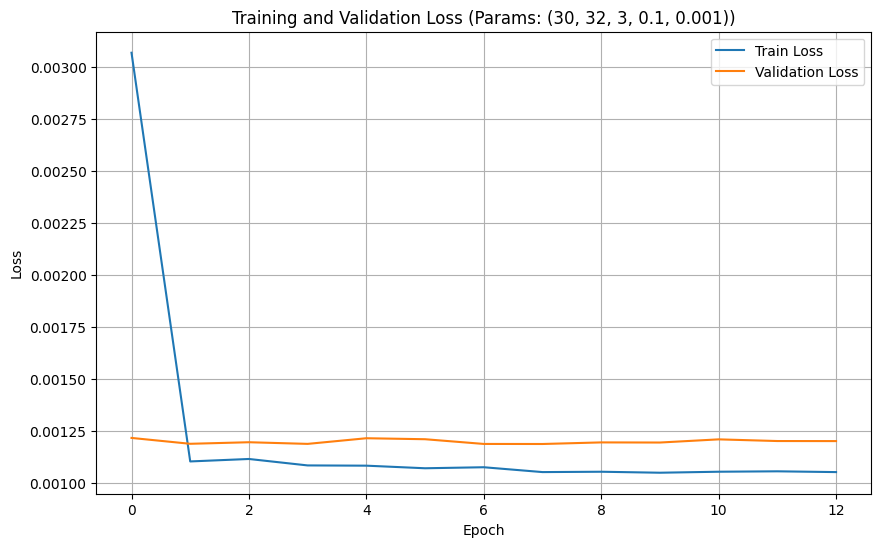

Testowanie kombinacji 6/48: (30, 32, 3, 0.1, 0.0001)
Epoch 1/20, Train Loss: 0.0362, Val Loss: 0.0158
Epoch 2/20, Train Loss: 0.0040, Val Loss: 0.0013
Epoch 3/20, Train Loss: 0.0014, Val Loss: 0.0013
Epoch 4/20, Train Loss: 0.0014, Val Loss: 0.0013
Epoch 5/20, Train Loss: 0.0014, Val Loss: 0.0013
Epoch 6/20, Train Loss: 0.0013, Val Loss: 0.0013
Epoch 7/20, Train Loss: 0.0013, Val Loss: 0.0012
Epoch 8/20, Train Loss: 0.0013, Val Loss: 0.0012
Epoch 9/20, Train Loss: 0.0013, Val Loss: 0.0013
Epoch 10/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 11/20, Train Loss: 0.0013, Val Loss: 0.0012
Epoch 12/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 13/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 14/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 15/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 16/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 17/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 18/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 19/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 

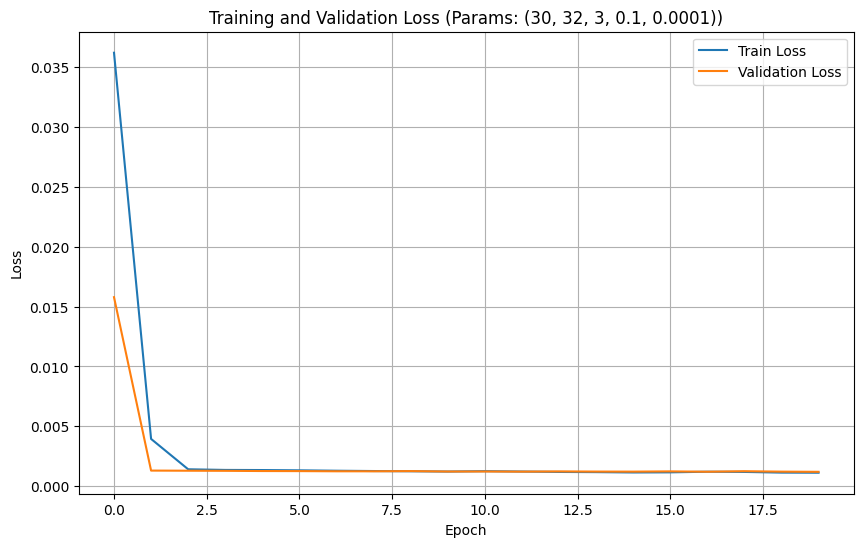

Testowanie kombinacji 7/48: (30, 32, 3, 0.2, 0.001)
Epoch 1/20, Train Loss: 0.0067, Val Loss: 0.0012
Epoch 2/20, Train Loss: 0.0013, Val Loss: 0.0012
Epoch 3/20, Train Loss: 0.0012, Val Loss: 0.0014
Epoch 4/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 5/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0012
Early stopping triggered at epoch 7


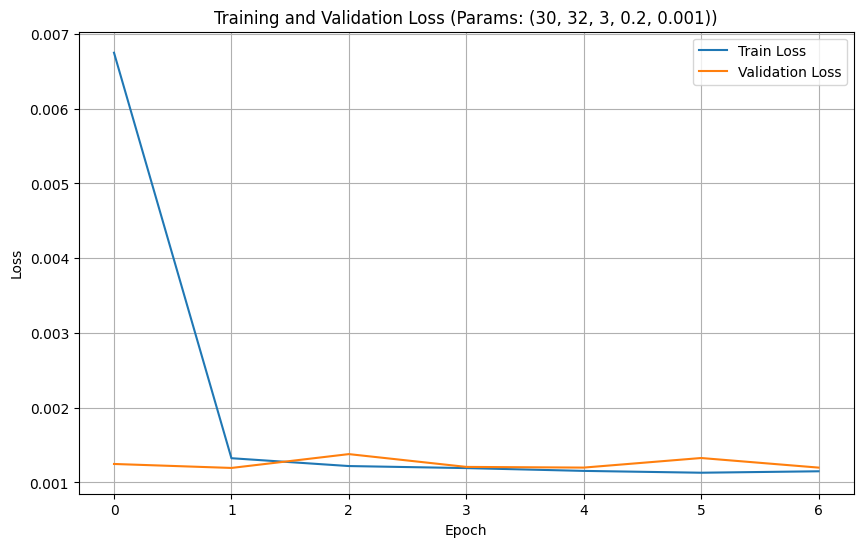

Testowanie kombinacji 8/48: (30, 32, 3, 0.2, 0.0001)
Epoch 1/20, Train Loss: 0.0563, Val Loss: 0.0401
Epoch 2/20, Train Loss: 0.0169, Val Loss: 0.0018
Epoch 3/20, Train Loss: 0.0020, Val Loss: 0.0013
Epoch 4/20, Train Loss: 0.0019, Val Loss: 0.0013
Epoch 5/20, Train Loss: 0.0017, Val Loss: 0.0013
Epoch 6/20, Train Loss: 0.0017, Val Loss: 0.0012
Epoch 7/20, Train Loss: 0.0016, Val Loss: 0.0012
Epoch 8/20, Train Loss: 0.0016, Val Loss: 0.0012
Epoch 9/20, Train Loss: 0.0015, Val Loss: 0.0012
Epoch 10/20, Train Loss: 0.0014, Val Loss: 0.0012
Epoch 11/20, Train Loss: 0.0015, Val Loss: 0.0012
Epoch 12/20, Train Loss: 0.0014, Val Loss: 0.0012
Epoch 13/20, Train Loss: 0.0014, Val Loss: 0.0012
Epoch 14/20, Train Loss: 0.0013, Val Loss: 0.0012
Epoch 15/20, Train Loss: 0.0013, Val Loss: 0.0012
Epoch 16/20, Train Loss: 0.0013, Val Loss: 0.0012
Epoch 17/20, Train Loss: 0.0013, Val Loss: 0.0012
Epoch 18/20, Train Loss: 0.0013, Val Loss: 0.0012
Early stopping triggered at epoch 18


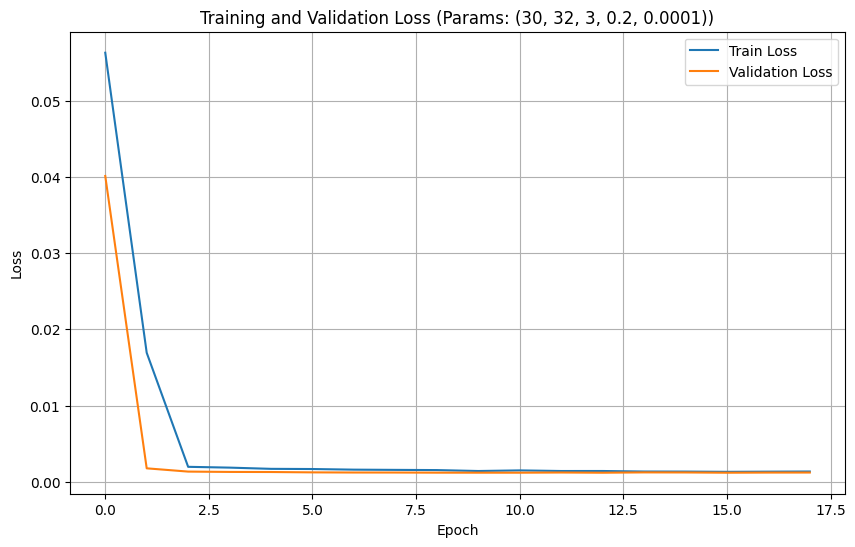

Testowanie kombinacji 9/48: (30, 64, 1, 0.1, 0.001)
Epoch 1/20, Train Loss: 0.0087, Val Loss: 0.0019
Epoch 2/20, Train Loss: 0.0015, Val Loss: 0.0014
Epoch 3/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 4/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 9/20, Train Loss: 0.0014, Val Loss: 0.0012
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 11/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 12/20, Train Loss: 0.0011, Val Loss: 0.0016
Epoch 13/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 14/20, Train Loss: 0.0011, Val Loss: 0.0015
Epoch 15/20, Train Loss: 0.0011, Val Loss: 0.0012
Early stopping triggered at epoch 15


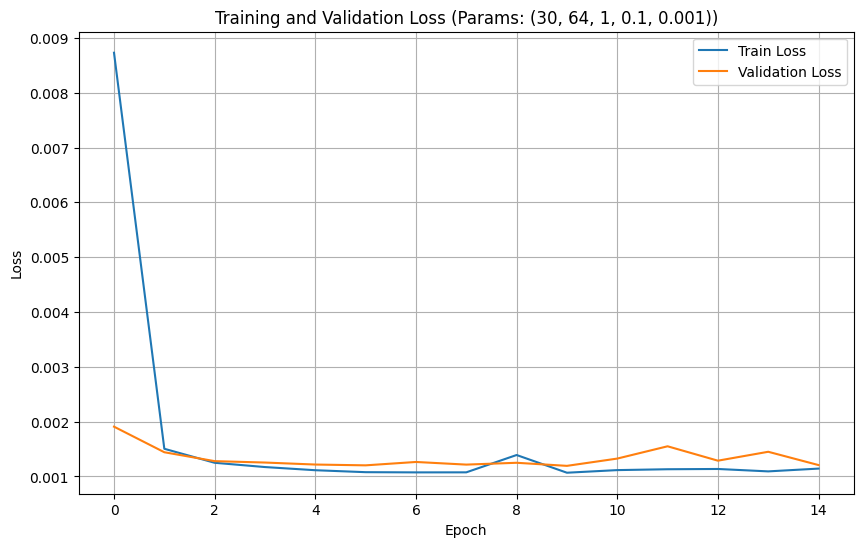

Testowanie kombinacji 10/48: (30, 64, 1, 0.1, 0.0001)
Epoch 1/20, Train Loss: 0.0490, Val Loss: 0.0338
Epoch 2/20, Train Loss: 0.0157, Val Loss: 0.0038
Epoch 3/20, Train Loss: 0.0033, Val Loss: 0.0028
Epoch 4/20, Train Loss: 0.0025, Val Loss: 0.0022
Epoch 5/20, Train Loss: 0.0020, Val Loss: 0.0018
Epoch 6/20, Train Loss: 0.0016, Val Loss: 0.0015
Epoch 7/20, Train Loss: 0.0014, Val Loss: 0.0014
Epoch 8/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 9/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 11/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 12/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 13/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 14/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 15/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 16/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 17/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 18/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 19/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch

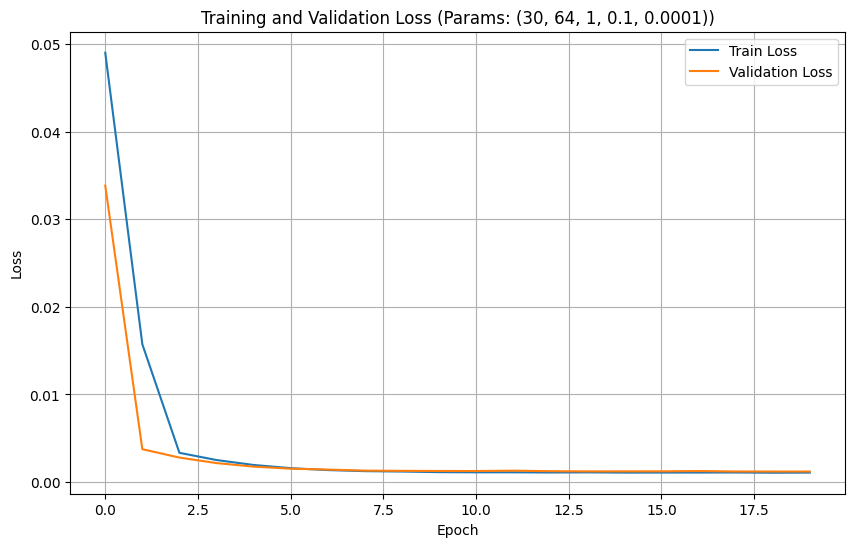

Testowanie kombinacji 11/48: (30, 64, 1, 0.2, 0.001)
Epoch 1/20, Train Loss: 0.0079, Val Loss: 0.0017
Epoch 2/20, Train Loss: 0.0016, Val Loss: 0.0013
Epoch 3/20, Train Loss: 0.0013, Val Loss: 0.0014
Epoch 4/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0014
Epoch 7/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 11/20, Train Loss: 0.0011, Val Loss: 0.0015
Epoch 12/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 13/20, Train Loss: 0.0011, Val Loss: 0.0014
Early stopping triggered at epoch 13


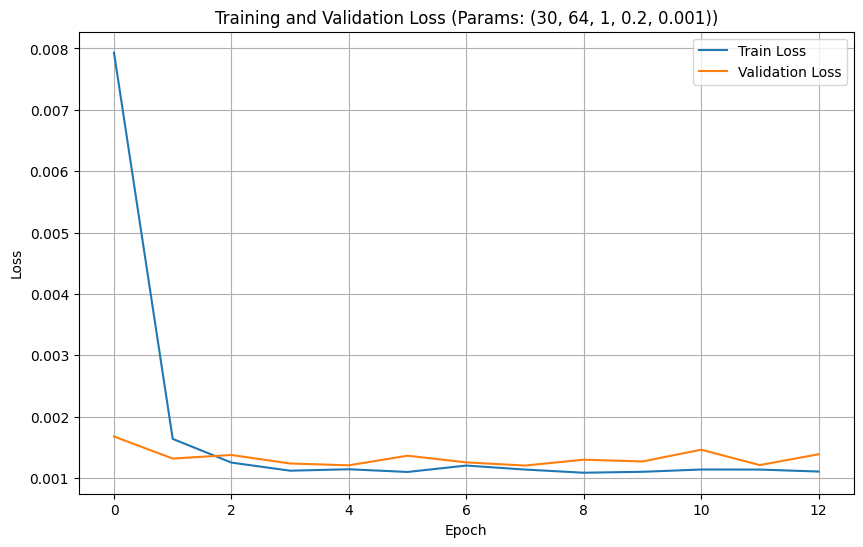

Testowanie kombinacji 12/48: (30, 64, 1, 0.2, 0.0001)
Epoch 1/20, Train Loss: 0.0429, Val Loss: 0.0274
Epoch 2/20, Train Loss: 0.0110, Val Loss: 0.0030
Epoch 3/20, Train Loss: 0.0027, Val Loss: 0.0023
Epoch 4/20, Train Loss: 0.0021, Val Loss: 0.0019
Epoch 5/20, Train Loss: 0.0017, Val Loss: 0.0017
Epoch 6/20, Train Loss: 0.0015, Val Loss: 0.0015
Epoch 7/20, Train Loss: 0.0014, Val Loss: 0.0015
Epoch 8/20, Train Loss: 0.0013, Val Loss: 0.0014
Epoch 9/20, Train Loss: 0.0013, Val Loss: 0.0014
Epoch 10/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 11/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 12/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 13/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 14/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 15/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 16/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 17/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 18/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 19/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch

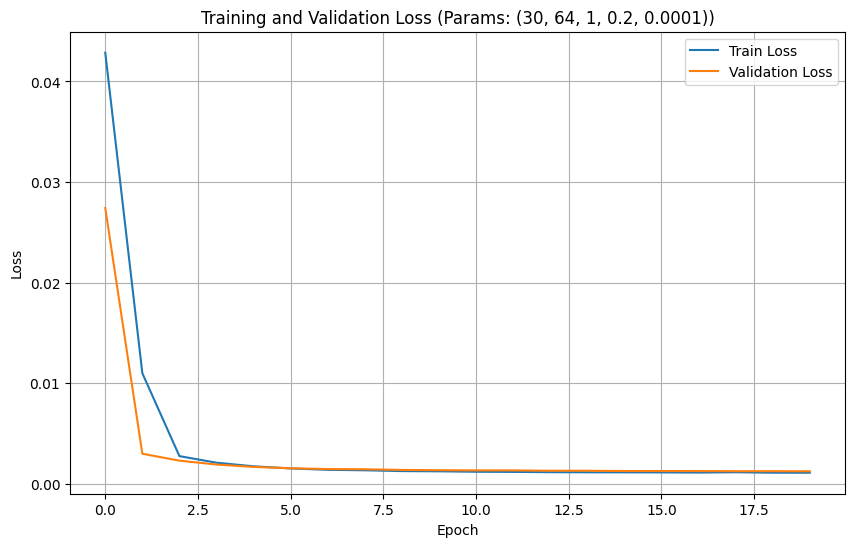

Testowanie kombinacji 13/48: (30, 64, 3, 0.1, 0.001)
Epoch 1/20, Train Loss: 0.0054, Val Loss: 0.0012
Epoch 2/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 3/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 4/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 7/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0012
Early stopping triggered at epoch 8


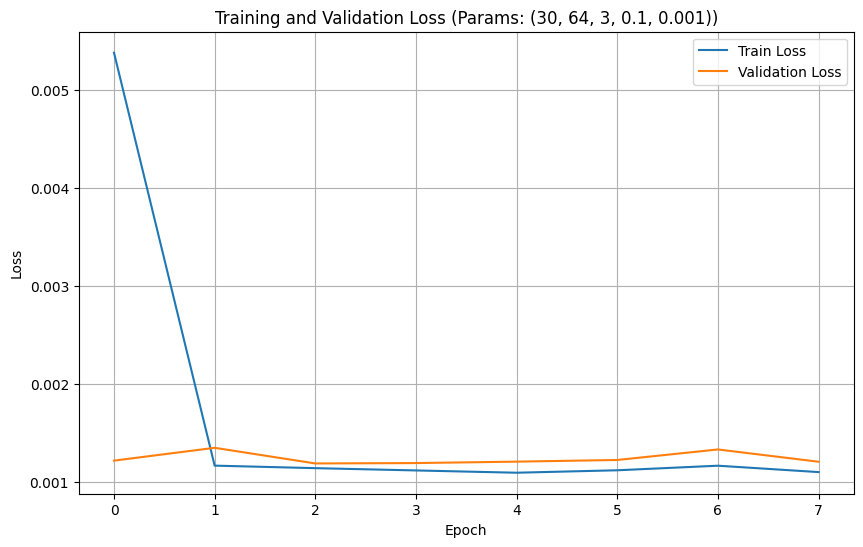

Testowanie kombinacji 14/48: (30, 64, 3, 0.1, 0.0001)
Epoch 1/20, Train Loss: 0.0218, Val Loss: 0.0025
Epoch 2/20, Train Loss: 0.0015, Val Loss: 0.0014
Epoch 3/20, Train Loss: 0.0013, Val Loss: 0.0013
Epoch 4/20, Train Loss: 0.0013, Val Loss: 0.0012
Epoch 5/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 6/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 7/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 9/20, Train Loss: 0.0013, Val Loss: 0.0012
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 11/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 12/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 13/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 14/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 15/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 16/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 17/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 18/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 19/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch

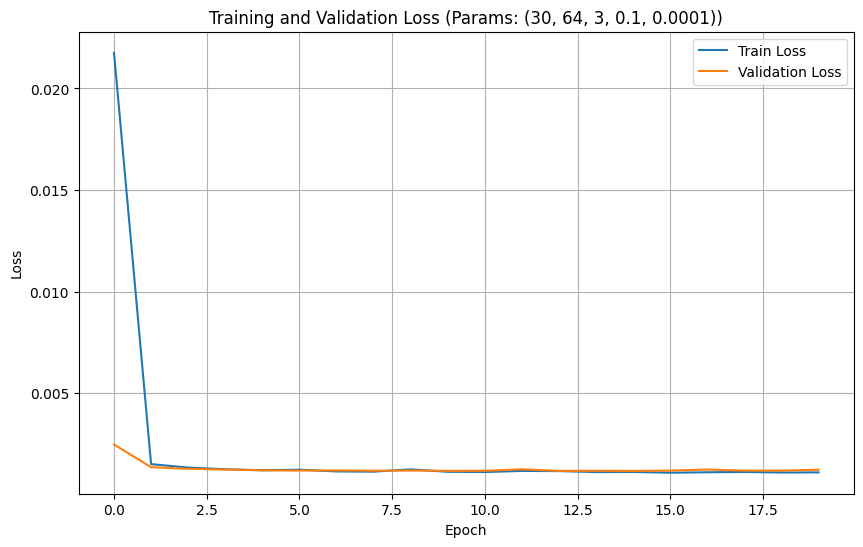

Testowanie kombinacji 15/48: (30, 64, 3, 0.2, 0.001)
Epoch 1/20, Train Loss: 0.0060, Val Loss: 0.0015
Epoch 2/20, Train Loss: 0.0013, Val Loss: 0.0012
Epoch 3/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 4/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0014
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0014
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 11/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 12/20, Train Loss: 0.0011, Val Loss: 0.0014
Epoch 13/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 14/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 15/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 16/20, Train Loss: 0.0011, Val Loss: 0.0012
Early stopping triggered at epoch 16


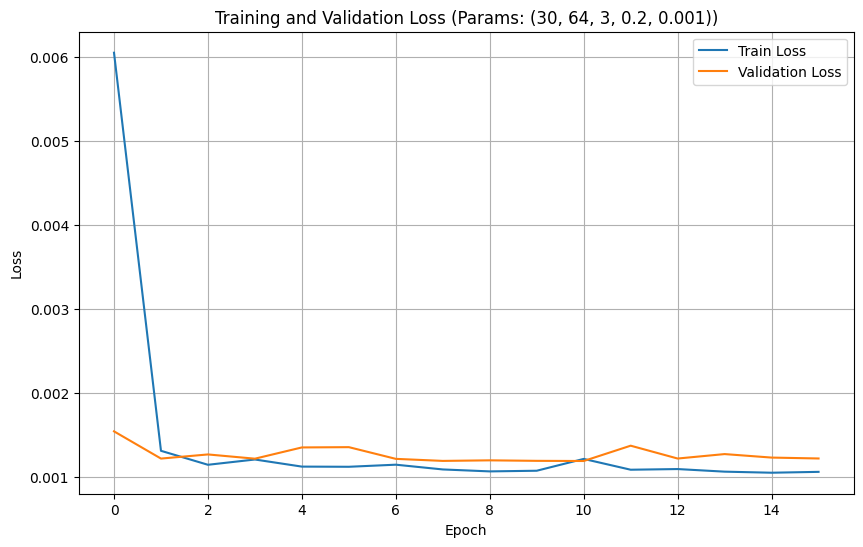

Testowanie kombinacji 16/48: (30, 64, 3, 0.2, 0.0001)
Epoch 1/20, Train Loss: 0.0191, Val Loss: 0.0014
Epoch 2/20, Train Loss: 0.0014, Val Loss: 0.0013
Epoch 3/20, Train Loss: 0.0014, Val Loss: 0.0012
Epoch 4/20, Train Loss: 0.0013, Val Loss: 0.0012
Epoch 5/20, Train Loss: 0.0013, Val Loss: 0.0012
Epoch 6/20, Train Loss: 0.0013, Val Loss: 0.0012
Epoch 7/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 8/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 9/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 10/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 11/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 12/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 13/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 14/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 15/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 16/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 17/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 18/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 19/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch

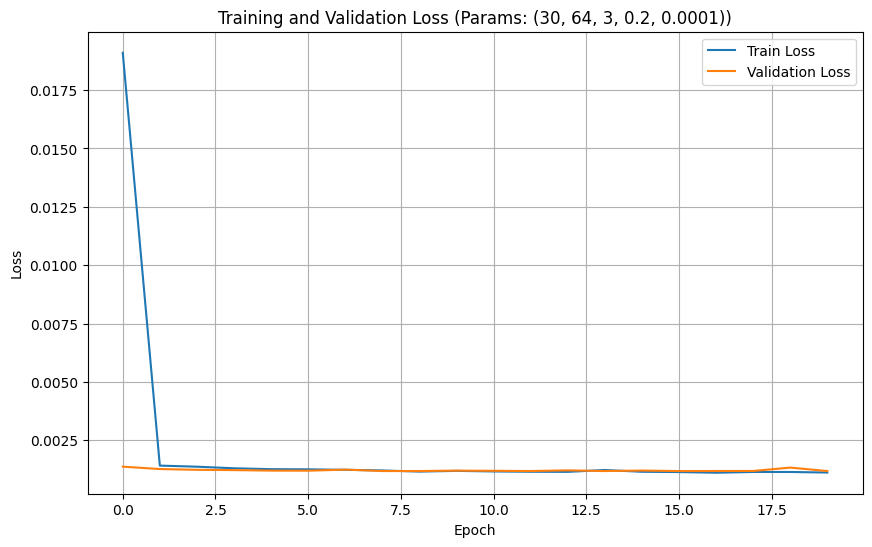

Testowanie kombinacji 17/48: (100, 32, 1, 0.1, 0.001)
Epoch 1/20, Train Loss: 0.0099, Val Loss: 0.0014
Epoch 2/20, Train Loss: 0.0013, Val Loss: 0.0011
Epoch 3/20, Train Loss: 0.0012, Val Loss: 0.0011
Epoch 4/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 11/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 12/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 13/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 14/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 15/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 16/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 17/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 18/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 19/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch

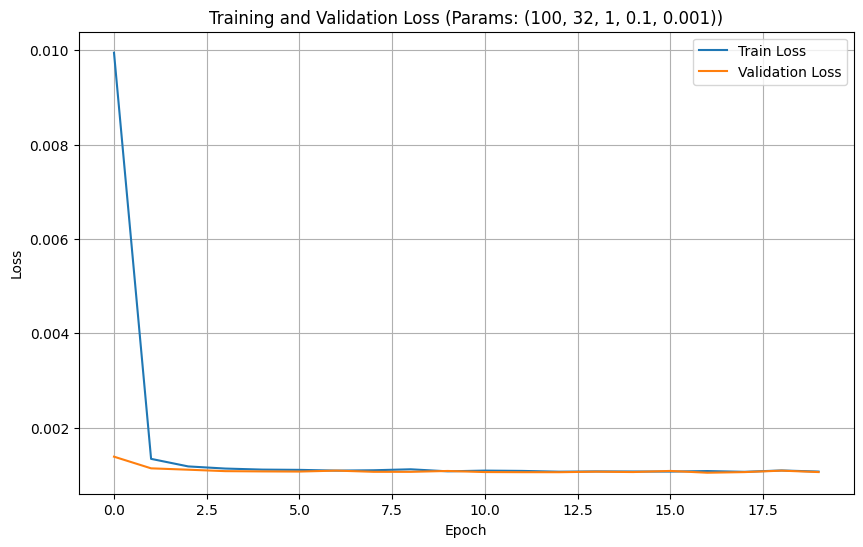

Testowanie kombinacji 18/48: (100, 32, 1, 0.1, 0.0001)
Epoch 1/20, Train Loss: 0.0411, Val Loss: 0.0310
Epoch 2/20, Train Loss: 0.0199, Val Loss: 0.0084
Epoch 3/20, Train Loss: 0.0038, Val Loss: 0.0025
Epoch 4/20, Train Loss: 0.0025, Val Loss: 0.0022
Epoch 5/20, Train Loss: 0.0021, Val Loss: 0.0019
Epoch 6/20, Train Loss: 0.0019, Val Loss: 0.0017
Epoch 7/20, Train Loss: 0.0017, Val Loss: 0.0016
Epoch 8/20, Train Loss: 0.0015, Val Loss: 0.0015
Epoch 9/20, Train Loss: 0.0015, Val Loss: 0.0014
Epoch 10/20, Train Loss: 0.0014, Val Loss: 0.0013
Epoch 11/20, Train Loss: 0.0013, Val Loss: 0.0013
Epoch 12/20, Train Loss: 0.0013, Val Loss: 0.0013
Epoch 13/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 14/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 15/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 16/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 17/20, Train Loss: 0.0012, Val Loss: 0.0011
Epoch 18/20, Train Loss: 0.0012, Val Loss: 0.0011
Epoch 19/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoc

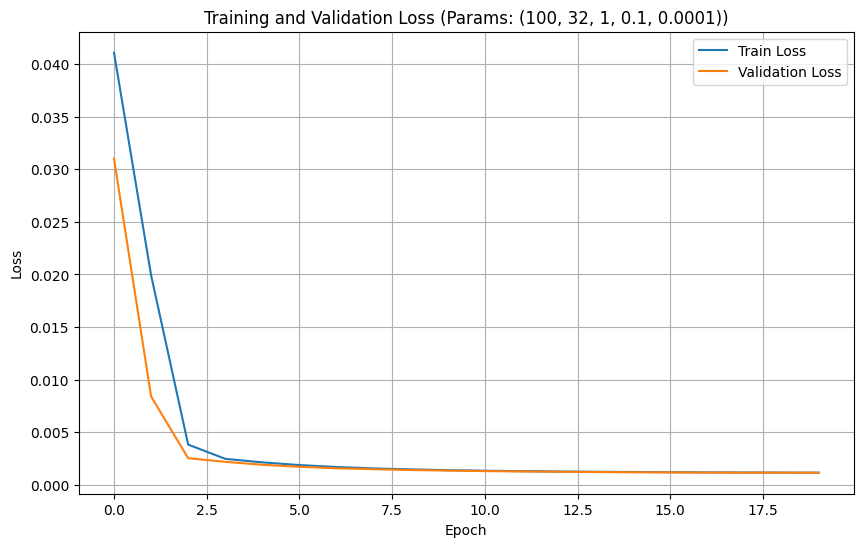

Testowanie kombinacji 19/48: (100, 32, 1, 0.2, 0.001)
Epoch 1/20, Train Loss: 0.0130, Val Loss: 0.0018
Epoch 2/20, Train Loss: 0.0016, Val Loss: 0.0014
Epoch 3/20, Train Loss: 0.0013, Val Loss: 0.0012
Epoch 4/20, Train Loss: 0.0012, Val Loss: 0.0011
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 11/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 12/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 13/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 14/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 15/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 16/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 17/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 18/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 19/20, Train Loss: 0.0011, Val Loss: 0.0011
Early

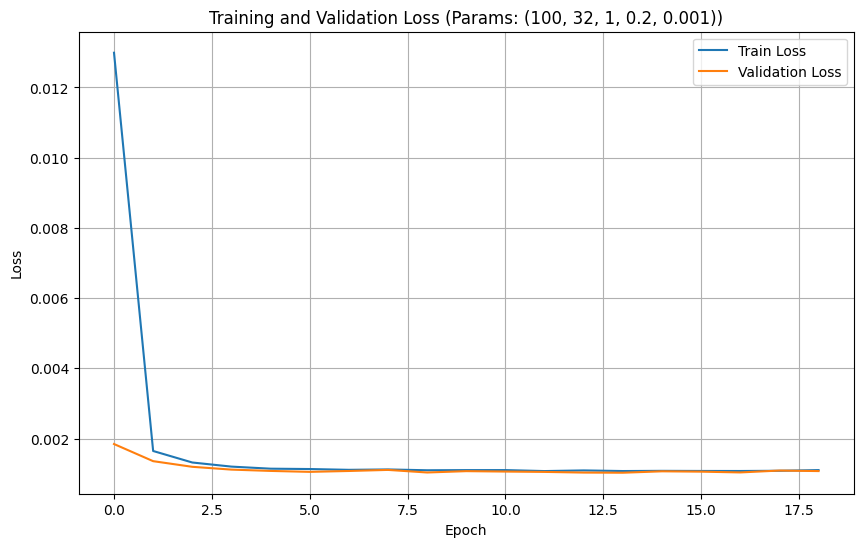

Testowanie kombinacji 20/48: (100, 32, 1, 0.2, 0.0001)
Epoch 1/20, Train Loss: 0.0362, Val Loss: 0.0274
Epoch 2/20, Train Loss: 0.0171, Val Loss: 0.0061
Epoch 3/20, Train Loss: 0.0028, Val Loss: 0.0019
Epoch 4/20, Train Loss: 0.0020, Val Loss: 0.0017
Epoch 5/20, Train Loss: 0.0018, Val Loss: 0.0016
Epoch 6/20, Train Loss: 0.0016, Val Loss: 0.0014
Epoch 7/20, Train Loss: 0.0015, Val Loss: 0.0014
Epoch 8/20, Train Loss: 0.0014, Val Loss: 0.0013
Epoch 9/20, Train Loss: 0.0013, Val Loss: 0.0013
Epoch 10/20, Train Loss: 0.0013, Val Loss: 0.0012
Epoch 11/20, Train Loss: 0.0013, Val Loss: 0.0012
Epoch 12/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 13/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 14/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 15/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 16/20, Train Loss: 0.0012, Val Loss: 0.0011
Epoch 17/20, Train Loss: 0.0012, Val Loss: 0.0011
Epoch 18/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 19/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoc

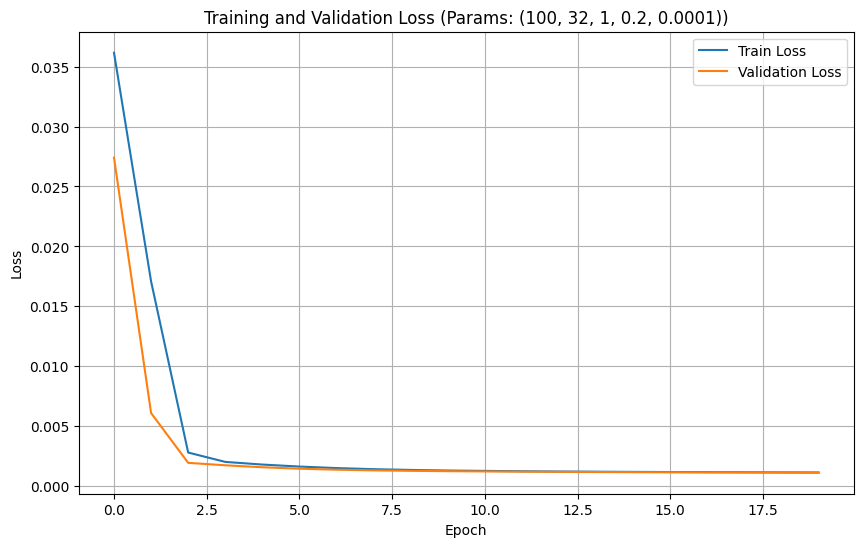

Testowanie kombinacji 21/48: (100, 32, 3, 0.1, 0.001)
Epoch 1/20, Train Loss: 0.0100, Val Loss: 0.0013
Epoch 2/20, Train Loss: 0.0013, Val Loss: 0.0011
Epoch 3/20, Train Loss: 0.0012, Val Loss: 0.0011
Epoch 4/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 11/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 12/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 13/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 14/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 15/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 16/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 17/20, Train Loss: 0.0011, Val Loss: 0.0011
Early stopping triggered at epoch 17


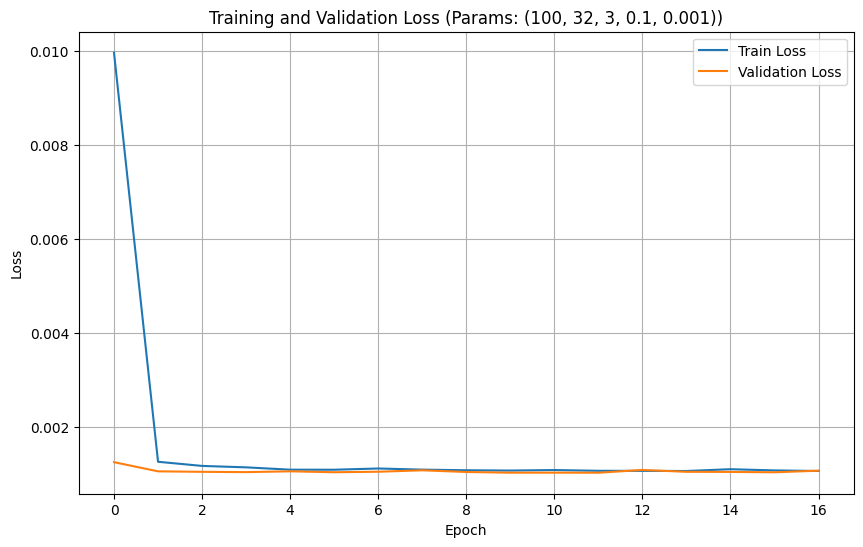

Testowanie kombinacji 22/48: (100, 32, 3, 0.1, 0.0001)
Epoch 1/20, Train Loss: 0.0285, Val Loss: 0.0107
Epoch 2/20, Train Loss: 0.0026, Val Loss: 0.0012
Epoch 3/20, Train Loss: 0.0014, Val Loss: 0.0011
Epoch 4/20, Train Loss: 0.0014, Val Loss: 0.0011
Epoch 5/20, Train Loss: 0.0013, Val Loss: 0.0011
Epoch 6/20, Train Loss: 0.0013, Val Loss: 0.0011
Epoch 7/20, Train Loss: 0.0012, Val Loss: 0.0011
Epoch 8/20, Train Loss: 0.0012, Val Loss: 0.0011
Epoch 9/20, Train Loss: 0.0012, Val Loss: 0.0011
Epoch 10/20, Train Loss: 0.0012, Val Loss: 0.0011
Epoch 11/20, Train Loss: 0.0012, Val Loss: 0.0011
Epoch 12/20, Train Loss: 0.0012, Val Loss: 0.0011
Epoch 13/20, Train Loss: 0.0012, Val Loss: 0.0010
Epoch 14/20, Train Loss: 0.0012, Val Loss: 0.0011
Epoch 15/20, Train Loss: 0.0012, Val Loss: 0.0010
Epoch 16/20, Train Loss: 0.0012, Val Loss: 0.0010
Epoch 17/20, Train Loss: 0.0012, Val Loss: 0.0010
Epoch 18/20, Train Loss: 0.0012, Val Loss: 0.0010
Epoch 19/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoc

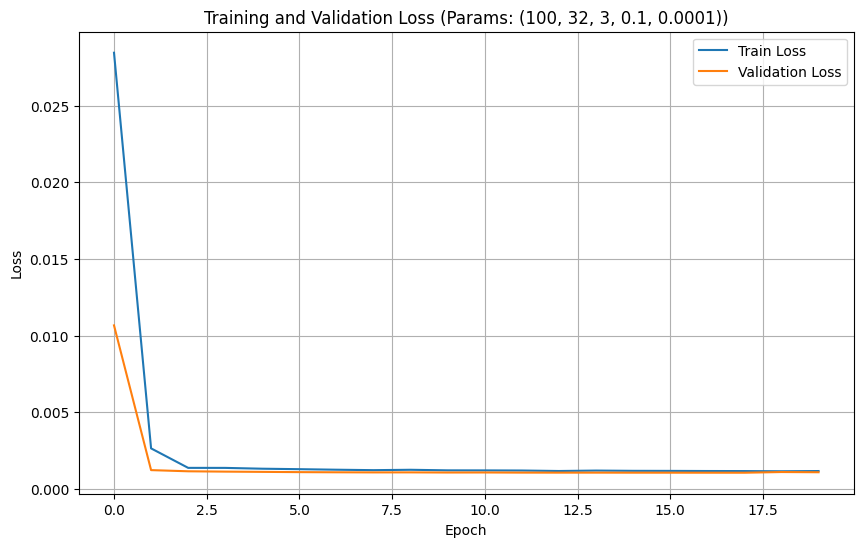

Testowanie kombinacji 23/48: (100, 32, 3, 0.2, 0.001)
Epoch 1/20, Train Loss: 0.0085, Val Loss: 0.0012
Epoch 2/20, Train Loss: 0.0015, Val Loss: 0.0011
Epoch 3/20, Train Loss: 0.0013, Val Loss: 0.0011
Epoch 4/20, Train Loss: 0.0012, Val Loss: 0.0010
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 11/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 12/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 13/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 14/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 15/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 16/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 17/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 18/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 19/20, Train Loss: 0.0011, Val Loss: 0.0010
Early

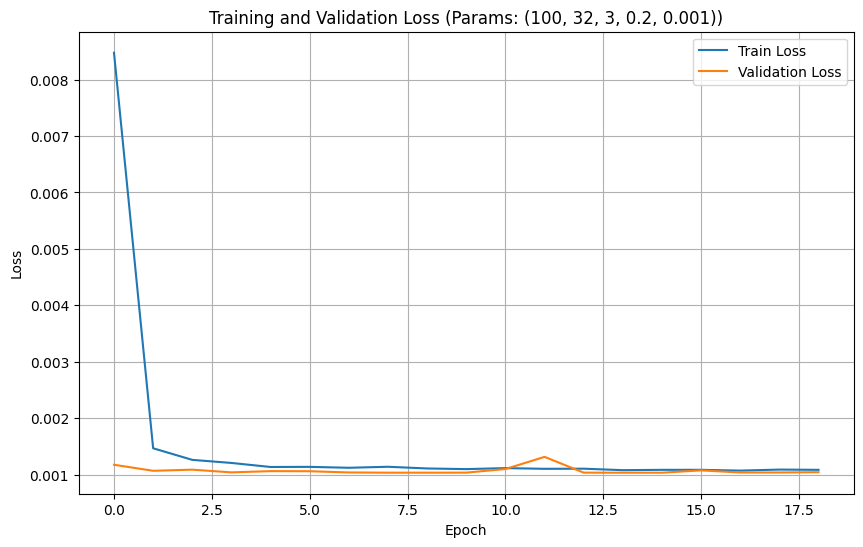

Testowanie kombinacji 24/48: (100, 32, 3, 0.2, 0.0001)
Epoch 1/20, Train Loss: 0.0402, Val Loss: 0.0236
Epoch 2/20, Train Loss: 0.0074, Val Loss: 0.0013
Epoch 3/20, Train Loss: 0.0018, Val Loss: 0.0012
Epoch 4/20, Train Loss: 0.0016, Val Loss: 0.0012
Epoch 5/20, Train Loss: 0.0016, Val Loss: 0.0012
Epoch 6/20, Train Loss: 0.0015, Val Loss: 0.0011
Epoch 7/20, Train Loss: 0.0014, Val Loss: 0.0011
Epoch 8/20, Train Loss: 0.0014, Val Loss: 0.0011
Epoch 9/20, Train Loss: 0.0014, Val Loss: 0.0011
Epoch 10/20, Train Loss: 0.0013, Val Loss: 0.0011
Epoch 11/20, Train Loss: 0.0013, Val Loss: 0.0011
Epoch 12/20, Train Loss: 0.0013, Val Loss: 0.0011
Epoch 13/20, Train Loss: 0.0013, Val Loss: 0.0011
Epoch 14/20, Train Loss: 0.0013, Val Loss: 0.0011
Epoch 15/20, Train Loss: 0.0012, Val Loss: 0.0011
Epoch 16/20, Train Loss: 0.0012, Val Loss: 0.0011
Epoch 17/20, Train Loss: 0.0012, Val Loss: 0.0011
Epoch 18/20, Train Loss: 0.0012, Val Loss: 0.0011
Epoch 19/20, Train Loss: 0.0012, Val Loss: 0.0011
Epoc

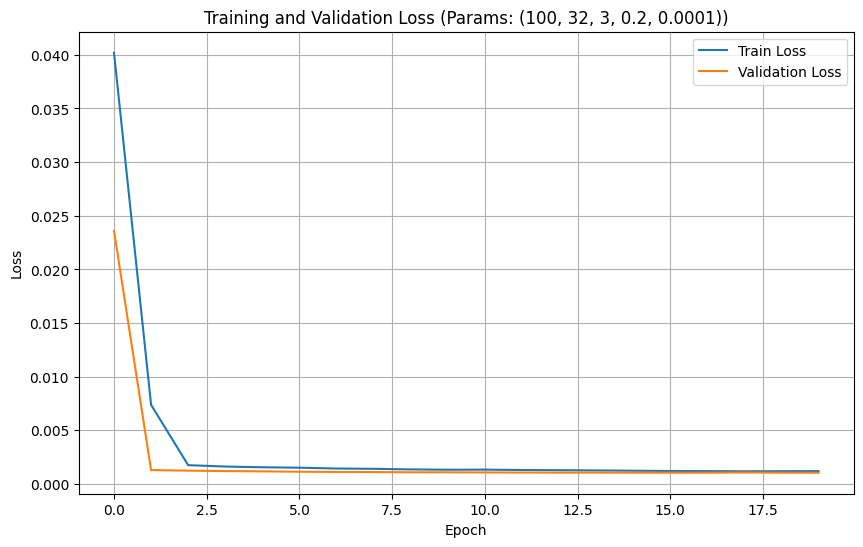

Testowanie kombinacji 25/48: (100, 64, 1, 0.1, 0.001)
Epoch 1/20, Train Loss: 0.0081, Val Loss: 0.0013
Epoch 2/20, Train Loss: 0.0012, Val Loss: 0.0011
Epoch 3/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 4/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0011
Early stopping triggered at epoch 10


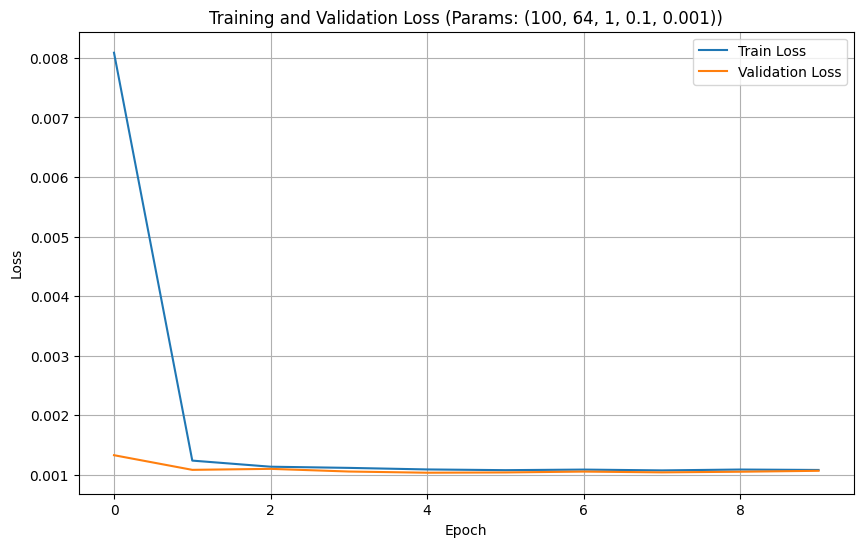

Testowanie kombinacji 26/48: (100, 64, 1, 0.1, 0.0001)
Epoch 1/20, Train Loss: 0.0372, Val Loss: 0.0203
Epoch 2/20, Train Loss: 0.0070, Val Loss: 0.0028
Epoch 3/20, Train Loss: 0.0026, Val Loss: 0.0022
Epoch 4/20, Train Loss: 0.0021, Val Loss: 0.0018
Epoch 5/20, Train Loss: 0.0017, Val Loss: 0.0015
Epoch 6/20, Train Loss: 0.0015, Val Loss: 0.0014
Epoch 7/20, Train Loss: 0.0013, Val Loss: 0.0013
Epoch 8/20, Train Loss: 0.0013, Val Loss: 0.0012
Epoch 9/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 10/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 11/20, Train Loss: 0.0012, Val Loss: 0.0011
Epoch 12/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 13/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 14/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 15/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 16/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 17/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 18/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 19/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoc

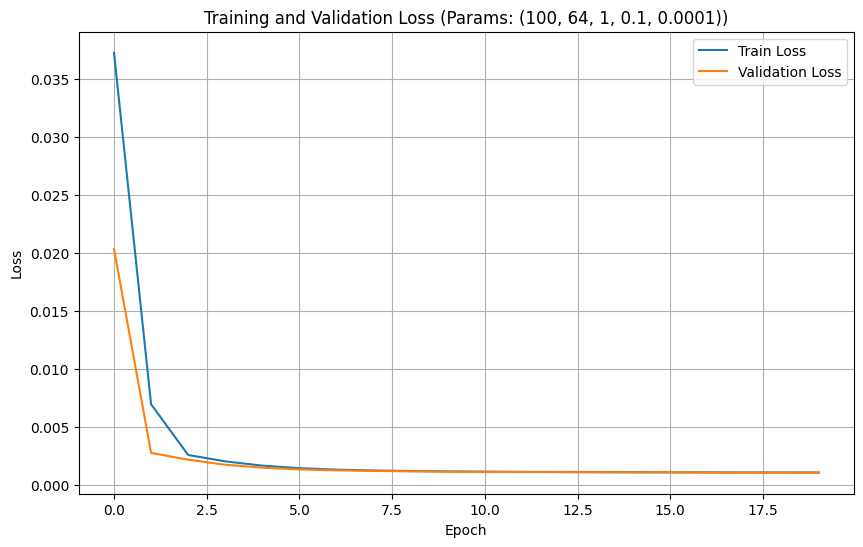

Testowanie kombinacji 27/48: (100, 64, 1, 0.2, 0.001)
Epoch 1/20, Train Loss: 0.0071, Val Loss: 0.0013
Epoch 2/20, Train Loss: 0.0012, Val Loss: 0.0011
Epoch 3/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 4/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 11/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 12/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 13/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 14/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 15/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 16/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 17/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 18/20, Train Loss: 0.0011, Val Loss: 0.0011
Early stopping triggered at epoch 18


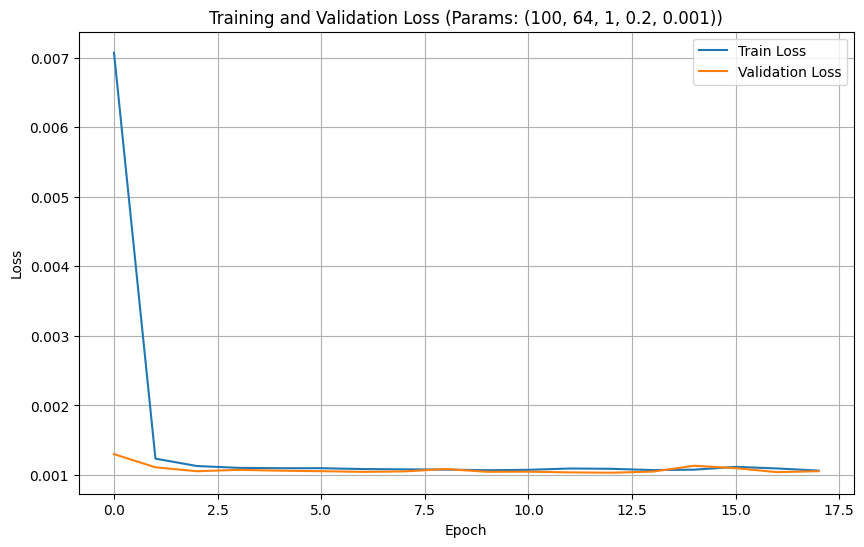

Testowanie kombinacji 28/48: (100, 64, 1, 0.2, 0.0001)
Epoch 1/20, Train Loss: 0.0508, Val Loss: 0.0364
Epoch 2/20, Train Loss: 0.0178, Val Loss: 0.0037
Epoch 3/20, Train Loss: 0.0035, Val Loss: 0.0027
Epoch 4/20, Train Loss: 0.0026, Val Loss: 0.0021
Epoch 5/20, Train Loss: 0.0021, Val Loss: 0.0017
Epoch 6/20, Train Loss: 0.0017, Val Loss: 0.0015
Epoch 7/20, Train Loss: 0.0015, Val Loss: 0.0014
Epoch 8/20, Train Loss: 0.0014, Val Loss: 0.0013
Epoch 9/20, Train Loss: 0.0013, Val Loss: 0.0013
Epoch 10/20, Train Loss: 0.0013, Val Loss: 0.0013
Epoch 11/20, Train Loss: 0.0013, Val Loss: 0.0013
Epoch 12/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 13/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 14/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 15/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 16/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 17/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 18/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 19/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoc

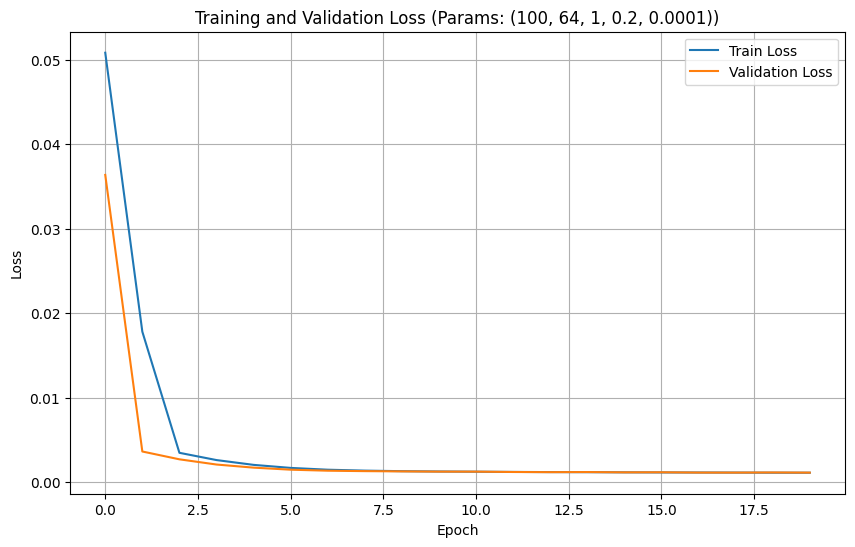

Testowanie kombinacji 29/48: (100, 64, 3, 0.1, 0.001)
Epoch 1/20, Train Loss: 0.0043, Val Loss: 0.0011
Epoch 2/20, Train Loss: 0.0012, Val Loss: 0.0011
Epoch 3/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 4/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 11/20, Train Loss: 0.0011, Val Loss: 0.0011
Early stopping triggered at epoch 11


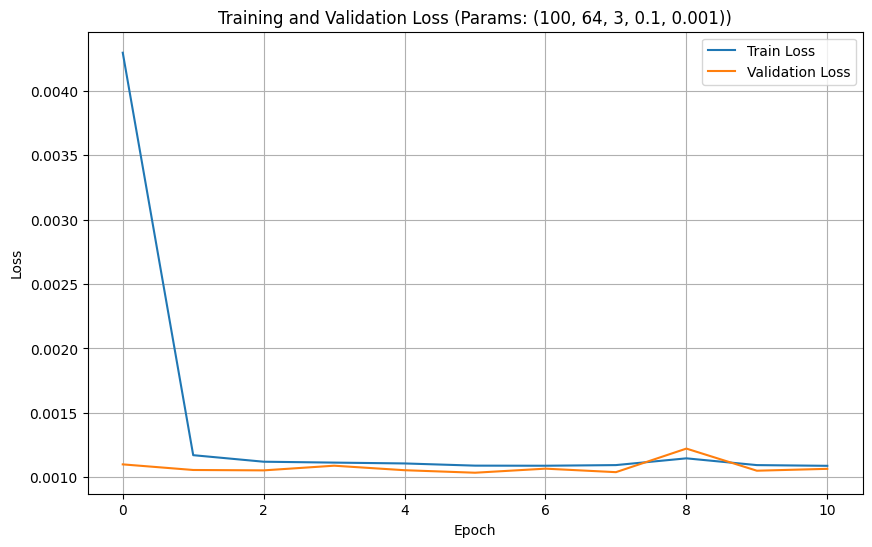

Testowanie kombinacji 30/48: (100, 64, 3, 0.1, 0.0001)
Epoch 1/20, Train Loss: 0.0187, Val Loss: 0.0015
Epoch 2/20, Train Loss: 0.0015, Val Loss: 0.0013
Epoch 3/20, Train Loss: 0.0014, Val Loss: 0.0012
Epoch 4/20, Train Loss: 0.0013, Val Loss: 0.0011
Epoch 5/20, Train Loss: 0.0012, Val Loss: 0.0011
Epoch 6/20, Train Loss: 0.0012, Val Loss: 0.0011
Epoch 7/20, Train Loss: 0.0012, Val Loss: 0.0011
Epoch 8/20, Train Loss: 0.0012, Val Loss: 0.0011
Epoch 9/20, Train Loss: 0.0012, Val Loss: 0.0011
Epoch 10/20, Train Loss: 0.0012, Val Loss: 0.0010
Epoch 11/20, Train Loss: 0.0012, Val Loss: 0.0010
Epoch 12/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 13/20, Train Loss: 0.0012, Val Loss: 0.0010
Epoch 14/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 15/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 16/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 17/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 18/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 19/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoc

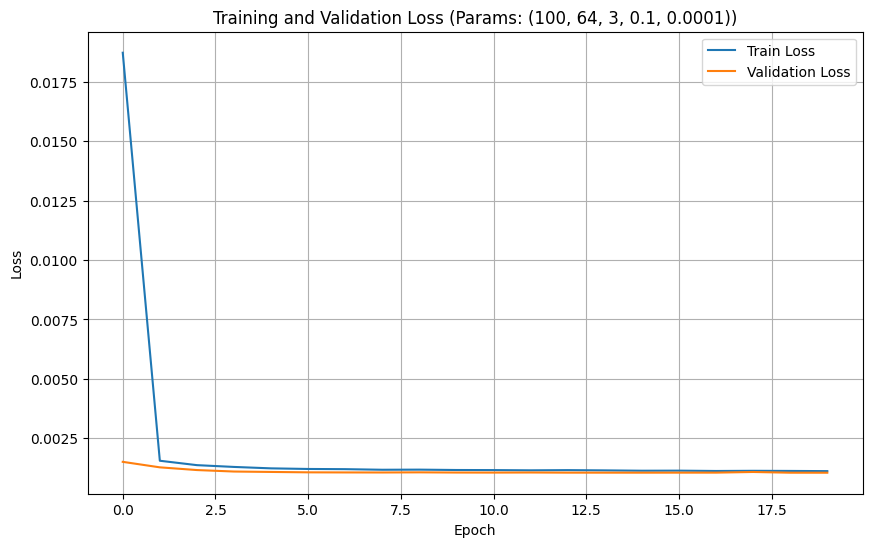

Testowanie kombinacji 31/48: (100, 64, 3, 0.2, 0.001)
Epoch 1/20, Train Loss: 0.0050, Val Loss: 0.0011
Epoch 2/20, Train Loss: 0.0012, Val Loss: 0.0011
Epoch 3/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 4/20, Train Loss: 0.0012, Val Loss: 0.0010
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 11/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 12/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 13/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 14/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 15/20, Train Loss: 0.0011, Val Loss: 0.0010
Epoch 16/20, Train Loss: 0.0011, Val Loss: 0.0011
Early stopping triggered at epoch 16


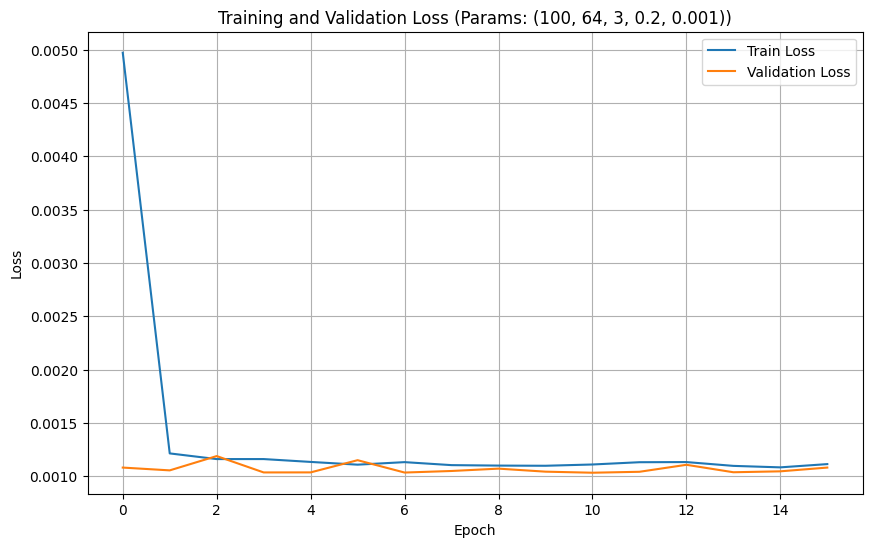

Testowanie kombinacji 32/48: (100, 64, 3, 0.2, 0.0001)
Epoch 1/20, Train Loss: 0.0268, Val Loss: 0.0028
Epoch 2/20, Train Loss: 0.0018, Val Loss: 0.0013
Epoch 3/20, Train Loss: 0.0015, Val Loss: 0.0012
Epoch 4/20, Train Loss: 0.0015, Val Loss: 0.0011
Epoch 5/20, Train Loss: 0.0014, Val Loss: 0.0011
Epoch 6/20, Train Loss: 0.0013, Val Loss: 0.0011
Epoch 7/20, Train Loss: 0.0013, Val Loss: 0.0011
Epoch 8/20, Train Loss: 0.0013, Val Loss: 0.0010
Epoch 9/20, Train Loss: 0.0012, Val Loss: 0.0010
Epoch 10/20, Train Loss: 0.0012, Val Loss: 0.0010
Epoch 11/20, Train Loss: 0.0012, Val Loss: 0.0010
Epoch 12/20, Train Loss: 0.0012, Val Loss: 0.0010
Epoch 13/20, Train Loss: 0.0012, Val Loss: 0.0011
Epoch 14/20, Train Loss: 0.0012, Val Loss: 0.0010
Epoch 15/20, Train Loss: 0.0012, Val Loss: 0.0010
Epoch 16/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 17/20, Train Loss: 0.0012, Val Loss: 0.0010
Epoch 18/20, Train Loss: 0.0012, Val Loss: 0.0010
Epoch 19/20, Train Loss: 0.0011, Val Loss: 0.0011
Earl

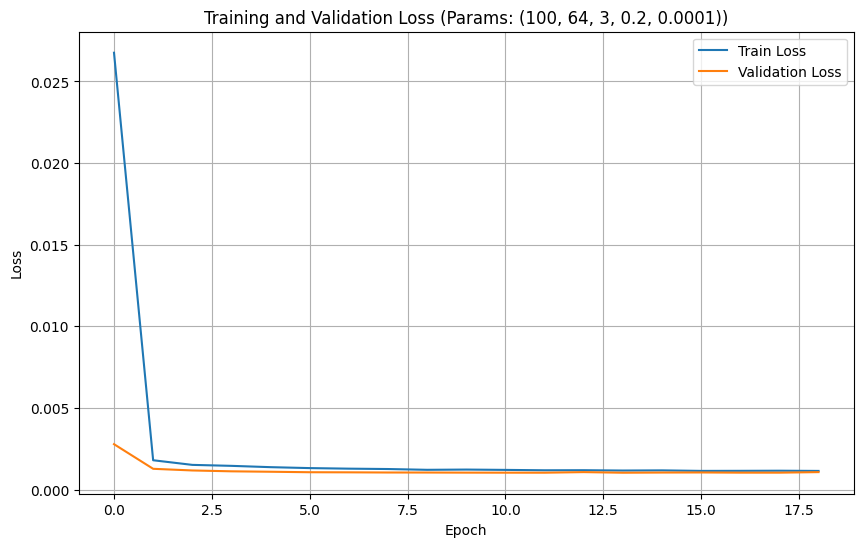

Testowanie kombinacji 33/48: (150, 32, 1, 0.1, 0.001)
Epoch 1/20, Train Loss: 0.0103, Val Loss: 0.0016
Epoch 2/20, Train Loss: 0.0014, Val Loss: 0.0014
Epoch 3/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 4/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 11/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 12/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 13/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 14/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 15/20, Train Loss: 0.0011, Val Loss: 0.0014
Early stopping triggered at epoch 15


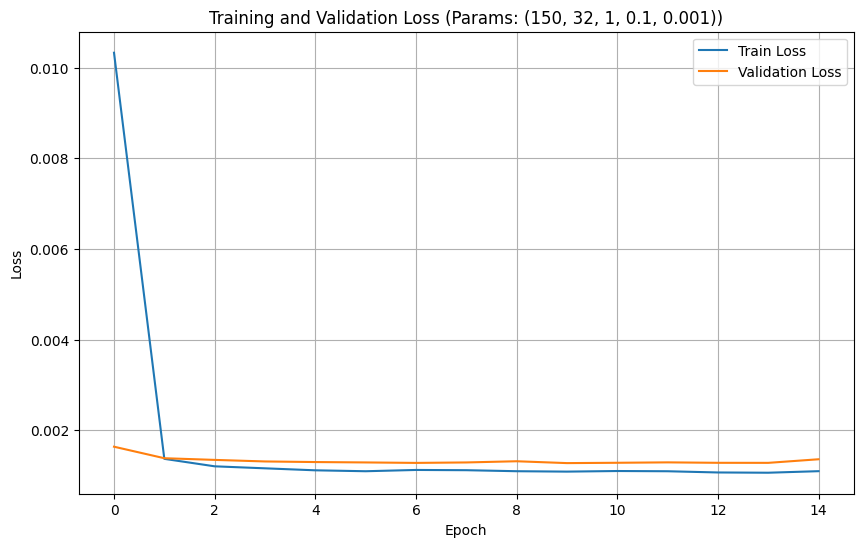

Testowanie kombinacji 34/48: (150, 32, 1, 0.1, 0.0001)
Epoch 1/20, Train Loss: 0.0031, Val Loss: 0.0022
Epoch 2/20, Train Loss: 0.0019, Val Loss: 0.0018
Epoch 3/20, Train Loss: 0.0017, Val Loss: 0.0016
Epoch 4/20, Train Loss: 0.0015, Val Loss: 0.0015
Epoch 5/20, Train Loss: 0.0014, Val Loss: 0.0015
Epoch 6/20, Train Loss: 0.0013, Val Loss: 0.0014
Epoch 7/20, Train Loss: 0.0013, Val Loss: 0.0014
Epoch 8/20, Train Loss: 0.0013, Val Loss: 0.0014
Epoch 9/20, Train Loss: 0.0012, Val Loss: 0.0014
Epoch 10/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 11/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 12/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 13/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 14/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 15/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 16/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 17/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 18/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 19/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoc

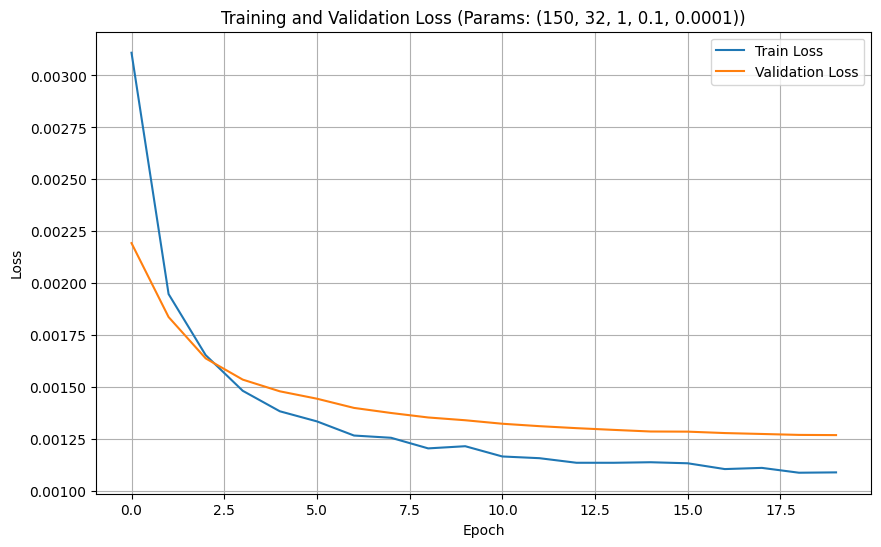

Testowanie kombinacji 35/48: (150, 32, 1, 0.2, 0.001)
Epoch 1/20, Train Loss: 0.0153, Val Loss: 0.0022
Epoch 2/20, Train Loss: 0.0015, Val Loss: 0.0014
Epoch 3/20, Train Loss: 0.0012, Val Loss: 0.0014
Epoch 4/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 5/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 11/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 12/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 13/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 14/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 15/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 16/20, Train Loss: 0.0011, Val Loss: 0.0013
Early stopping triggered at epoch 16


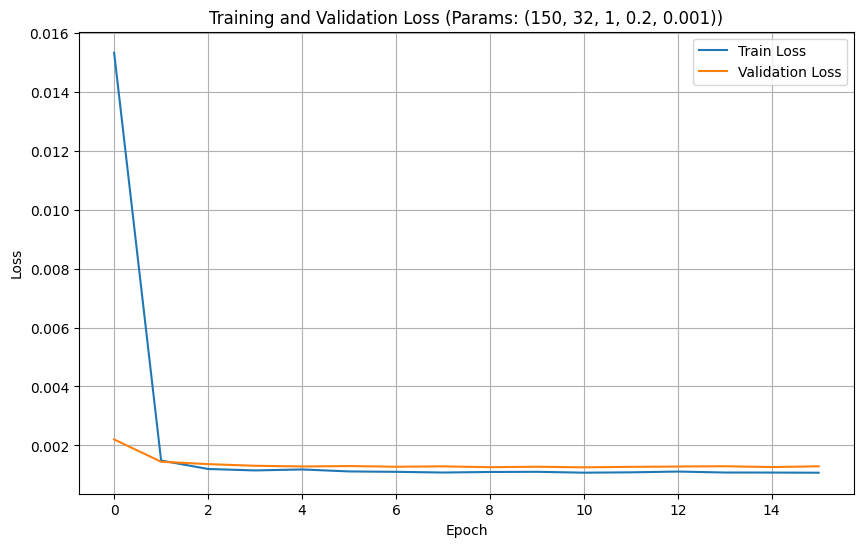

Testowanie kombinacji 36/48: (150, 32, 1, 0.2, 0.0001)
Epoch 1/20, Train Loss: 0.0556, Val Loss: 0.0430
Epoch 2/20, Train Loss: 0.0304, Val Loss: 0.0151
Epoch 3/20, Train Loss: 0.0053, Val Loss: 0.0023
Epoch 4/20, Train Loss: 0.0021, Val Loss: 0.0021
Epoch 5/20, Train Loss: 0.0019, Val Loss: 0.0020
Epoch 6/20, Train Loss: 0.0018, Val Loss: 0.0019
Epoch 7/20, Train Loss: 0.0017, Val Loss: 0.0018
Epoch 8/20, Train Loss: 0.0016, Val Loss: 0.0017
Epoch 9/20, Train Loss: 0.0016, Val Loss: 0.0017
Epoch 10/20, Train Loss: 0.0015, Val Loss: 0.0016
Epoch 11/20, Train Loss: 0.0014, Val Loss: 0.0016
Epoch 12/20, Train Loss: 0.0014, Val Loss: 0.0015
Epoch 13/20, Train Loss: 0.0013, Val Loss: 0.0015
Epoch 14/20, Train Loss: 0.0013, Val Loss: 0.0015
Epoch 15/20, Train Loss: 0.0013, Val Loss: 0.0015
Epoch 16/20, Train Loss: 0.0013, Val Loss: 0.0015
Epoch 17/20, Train Loss: 0.0012, Val Loss: 0.0014
Epoch 18/20, Train Loss: 0.0013, Val Loss: 0.0014
Epoch 19/20, Train Loss: 0.0012, Val Loss: 0.0014
Epoc

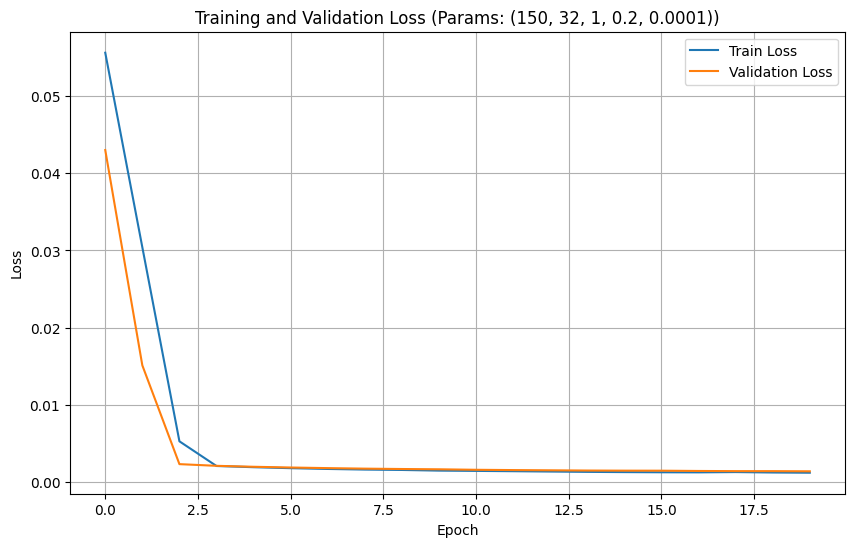

Testowanie kombinacji 37/48: (150, 32, 3, 0.1, 0.001)
Epoch 1/20, Train Loss: 0.0071, Val Loss: 0.0014
Epoch 2/20, Train Loss: 0.0013, Val Loss: 0.0013
Epoch 3/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 4/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 7/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0012
Early stopping triggered at epoch 9


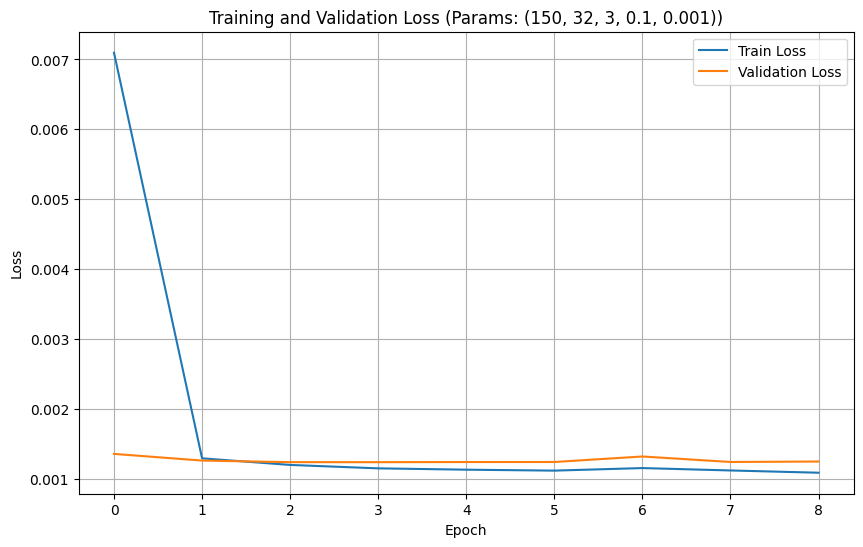

Testowanie kombinacji 38/48: (150, 32, 3, 0.1, 0.0001)
Epoch 1/20, Train Loss: 0.0385, Val Loss: 0.0212
Epoch 2/20, Train Loss: 0.0059, Val Loss: 0.0013
Epoch 3/20, Train Loss: 0.0013, Val Loss: 0.0013
Epoch 4/20, Train Loss: 0.0013, Val Loss: 0.0013
Epoch 5/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 6/20, Train Loss: 0.0013, Val Loss: 0.0012
Epoch 7/20, Train Loss: 0.0013, Val Loss: 0.0012
Epoch 8/20, Train Loss: 0.0013, Val Loss: 0.0013
Epoch 9/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 10/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 11/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 12/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 13/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 14/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 15/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 16/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 17/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 18/20, Train Loss: 0.0012, Val Loss: 0.0012
Early stopping triggered at epoch 18


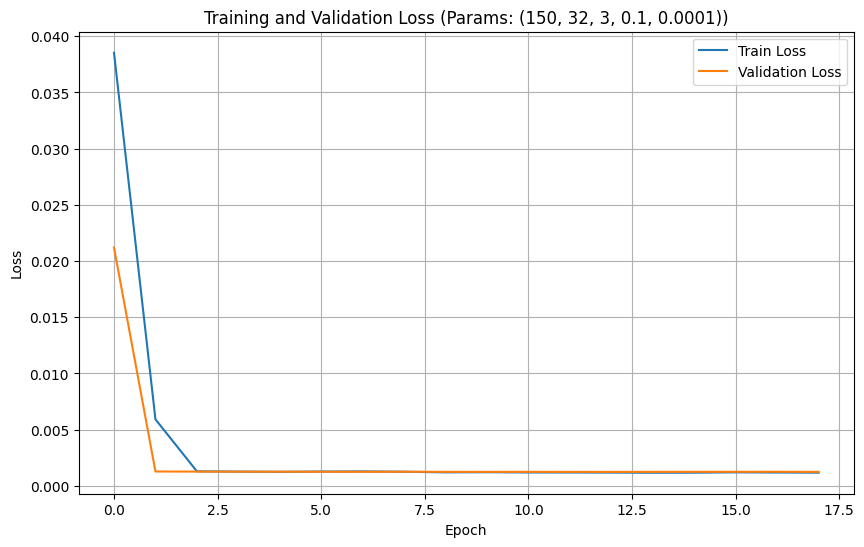

Testowanie kombinacji 39/48: (150, 32, 3, 0.2, 0.001)
Epoch 1/20, Train Loss: 0.0089, Val Loss: 0.0013
Epoch 2/20, Train Loss: 0.0014, Val Loss: 0.0013
Epoch 3/20, Train Loss: 0.0013, Val Loss: 0.0012
Epoch 4/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 5/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 6/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0013
Early stopping triggered at epoch 8


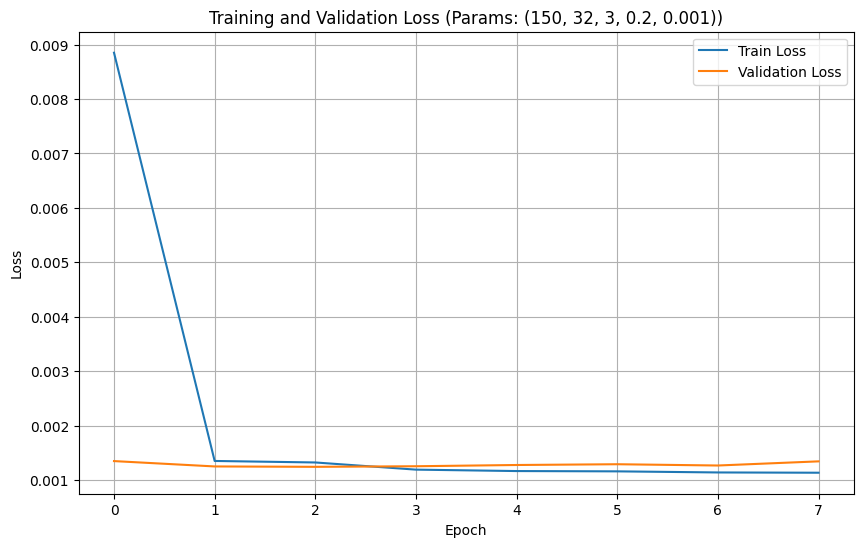

Testowanie kombinacji 40/48: (150, 32, 3, 0.2, 0.0001)
Epoch 1/20, Train Loss: 0.0104, Val Loss: 0.0015
Epoch 2/20, Train Loss: 0.0014, Val Loss: 0.0013
Epoch 3/20, Train Loss: 0.0013, Val Loss: 0.0013
Epoch 4/20, Train Loss: 0.0013, Val Loss: 0.0013
Epoch 5/20, Train Loss: 0.0013, Val Loss: 0.0013
Epoch 6/20, Train Loss: 0.0013, Val Loss: 0.0013
Epoch 7/20, Train Loss: 0.0013, Val Loss: 0.0013
Epoch 8/20, Train Loss: 0.0013, Val Loss: 0.0013
Epoch 9/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 10/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 11/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 12/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 13/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 14/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 15/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 16/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 17/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 18/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 19/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoc

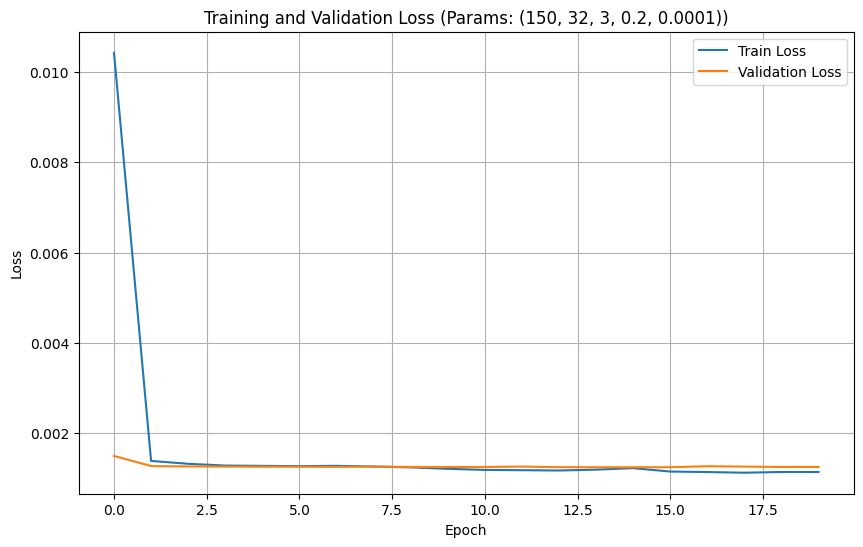

Testowanie kombinacji 41/48: (150, 64, 1, 0.1, 0.001)
Epoch 1/20, Train Loss: 0.0066, Val Loss: 0.0018
Epoch 2/20, Train Loss: 0.0013, Val Loss: 0.0014
Epoch 3/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 4/20, Train Loss: 0.0012, Val Loss: 0.0015
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 10/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 11/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 12/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 13/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 14/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 15/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 16/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 17/20, Train Loss: 0.0011, Val Loss: 0.0013
Early stopping triggered at epoch 17


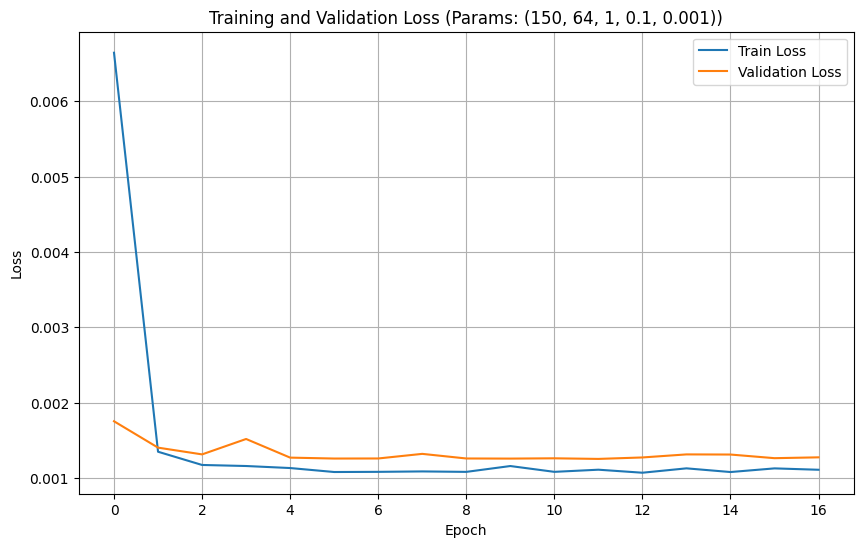

Testowanie kombinacji 42/48: (150, 64, 1, 0.1, 0.0001)
Epoch 1/20, Train Loss: 0.0310, Val Loss: 0.0128
Epoch 2/20, Train Loss: 0.0043, Val Loss: 0.0027
Epoch 3/20, Train Loss: 0.0023, Val Loss: 0.0021
Epoch 4/20, Train Loss: 0.0018, Val Loss: 0.0018
Epoch 5/20, Train Loss: 0.0015, Val Loss: 0.0016
Epoch 6/20, Train Loss: 0.0014, Val Loss: 0.0015
Epoch 7/20, Train Loss: 0.0013, Val Loss: 0.0014
Epoch 8/20, Train Loss: 0.0013, Val Loss: 0.0014
Epoch 9/20, Train Loss: 0.0012, Val Loss: 0.0014
Epoch 10/20, Train Loss: 0.0012, Val Loss: 0.0014
Epoch 11/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 12/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 13/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 14/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 15/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 16/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 17/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 18/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 19/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoc

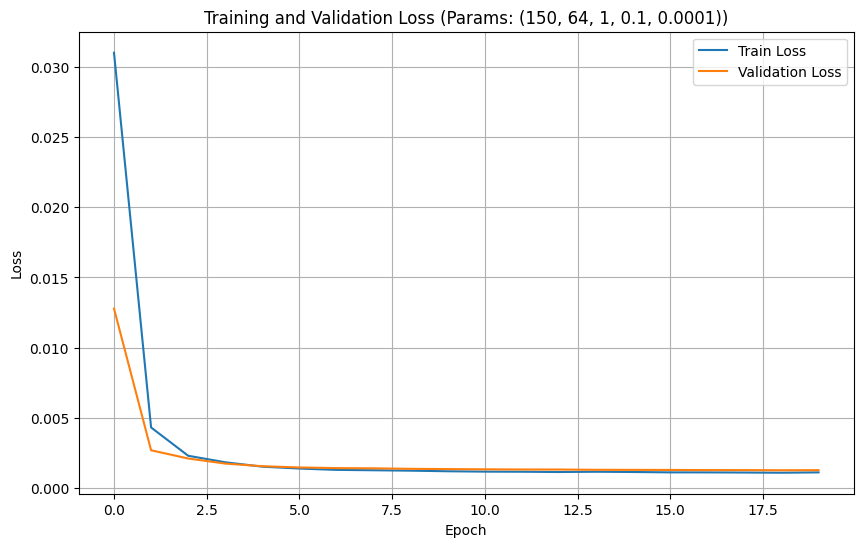

Testowanie kombinacji 43/48: (150, 64, 1, 0.2, 0.001)
Epoch 1/20, Train Loss: 0.0068, Val Loss: 0.0016
Epoch 2/20, Train Loss: 0.0012, Val Loss: 0.0014
Epoch 3/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 4/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 11/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 12/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 13/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 14/20, Train Loss: 0.0011, Val Loss: 0.0013
Early stopping triggered at epoch 14


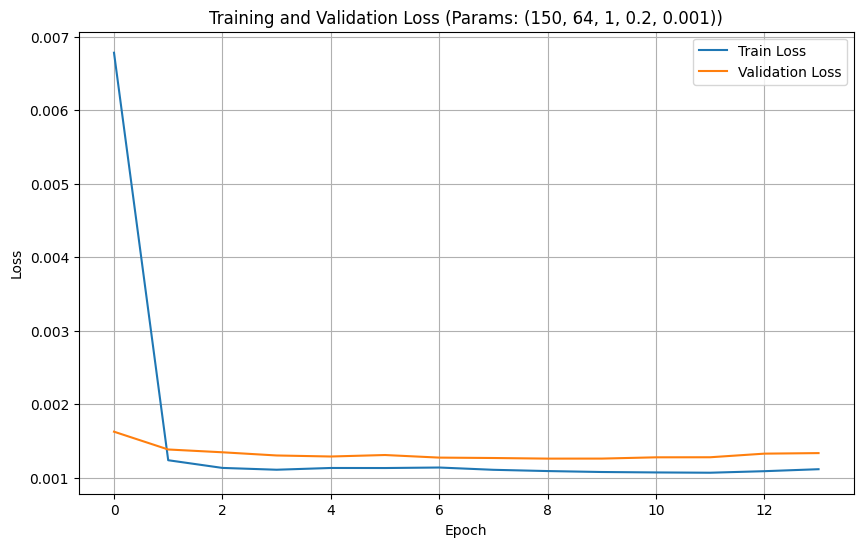

Testowanie kombinacji 44/48: (150, 64, 1, 0.2, 0.0001)
Epoch 1/20, Train Loss: 0.0347, Val Loss: 0.0179
Epoch 2/20, Train Loss: 0.0060, Val Loss: 0.0025
Epoch 3/20, Train Loss: 0.0022, Val Loss: 0.0020
Epoch 4/20, Train Loss: 0.0018, Val Loss: 0.0017
Epoch 5/20, Train Loss: 0.0016, Val Loss: 0.0016
Epoch 6/20, Train Loss: 0.0014, Val Loss: 0.0015
Epoch 7/20, Train Loss: 0.0013, Val Loss: 0.0014
Epoch 8/20, Train Loss: 0.0013, Val Loss: 0.0014
Epoch 9/20, Train Loss: 0.0012, Val Loss: 0.0014
Epoch 10/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 11/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 12/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 13/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 14/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 15/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 16/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 17/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 18/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 19/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoc

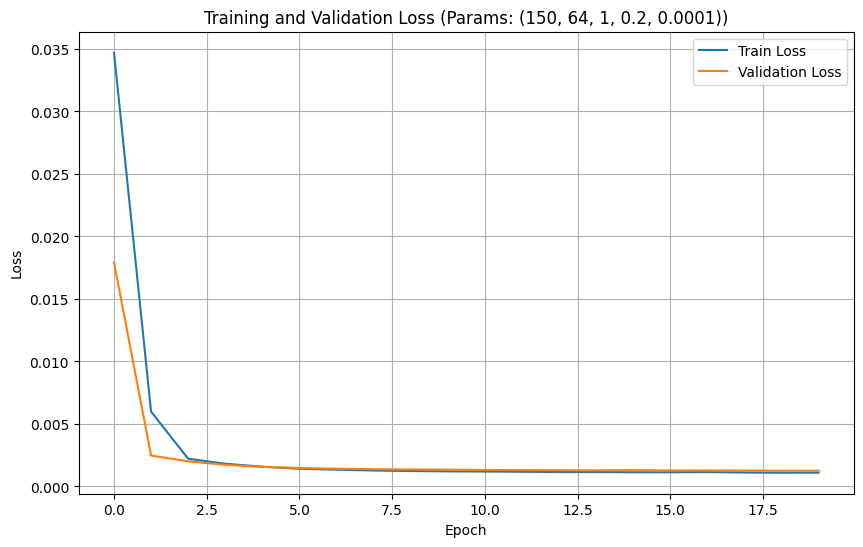

Testowanie kombinacji 45/48: (150, 64, 3, 0.1, 0.001)
Epoch 1/20, Train Loss: 0.0058, Val Loss: 0.0013
Epoch 2/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 3/20, Train Loss: 0.0011, Val Loss: 0.0014
Epoch 4/20, Train Loss: 0.0011, Val Loss: 0.0014
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0014
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0013
Early stopping triggered at epoch 10


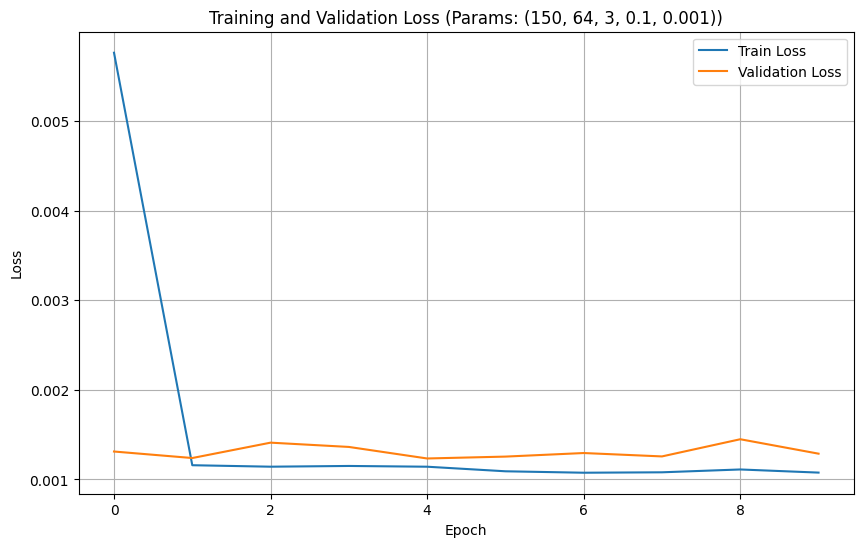

Testowanie kombinacji 46/48: (150, 64, 3, 0.1, 0.0001)
Epoch 1/20, Train Loss: 0.0197, Val Loss: 0.0025
Epoch 2/20, Train Loss: 0.0014, Val Loss: 0.0013
Epoch 3/20, Train Loss: 0.0013, Val Loss: 0.0013
Epoch 4/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 5/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 6/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 7/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 10/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 11/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 12/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 13/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 14/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 15/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 16/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 17/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 18/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 19/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoc

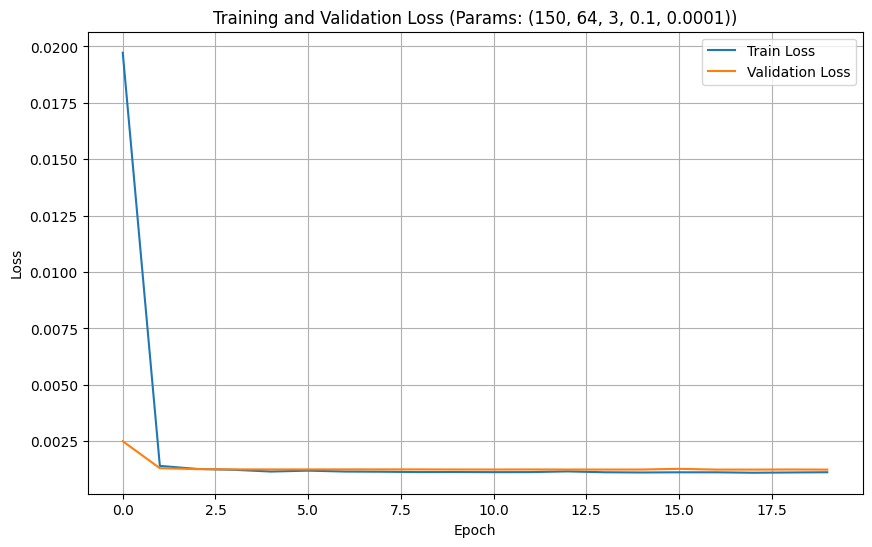

Testowanie kombinacji 47/48: (150, 64, 3, 0.2, 0.001)
Epoch 1/20, Train Loss: 0.0054, Val Loss: 0.0014
Epoch 2/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 3/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 4/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 5/20, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 6/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 7/20, Train Loss: 0.0011, Val Loss: 0.0012
Epoch 8/20, Train Loss: 0.0011, Val Loss: 0.0014
Epoch 9/20, Train Loss: 0.0011, Val Loss: 0.0013
Early stopping triggered at epoch 9


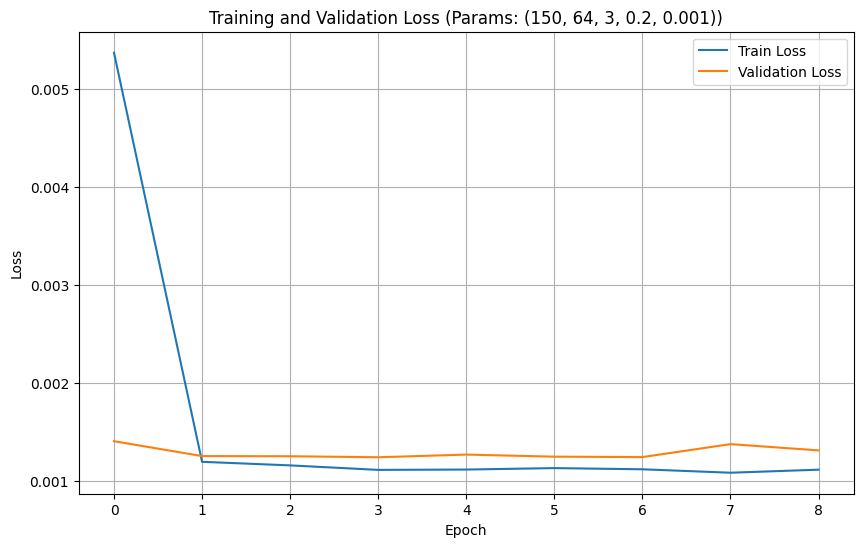

Testowanie kombinacji 48/48: (150, 64, 3, 0.2, 0.0001)
Epoch 1/20, Train Loss: 0.0334, Val Loss: 0.0040
Epoch 2/20, Train Loss: 0.0023, Val Loss: 0.0016
Epoch 3/20, Train Loss: 0.0019, Val Loss: 0.0015
Epoch 4/20, Train Loss: 0.0017, Val Loss: 0.0014
Epoch 5/20, Train Loss: 0.0016, Val Loss: 0.0013
Epoch 6/20, Train Loss: 0.0015, Val Loss: 0.0013
Epoch 7/20, Train Loss: 0.0014, Val Loss: 0.0013
Epoch 8/20, Train Loss: 0.0014, Val Loss: 0.0013
Epoch 9/20, Train Loss: 0.0014, Val Loss: 0.0013
Epoch 10/20, Train Loss: 0.0013, Val Loss: 0.0012
Epoch 11/20, Train Loss: 0.0013, Val Loss: 0.0013
Epoch 12/20, Train Loss: 0.0013, Val Loss: 0.0012
Epoch 13/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 14/20, Train Loss: 0.0013, Val Loss: 0.0012
Epoch 15/20, Train Loss: 0.0012, Val Loss: 0.0012
Epoch 16/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 17/20, Train Loss: 0.0012, Val Loss: 0.0013
Early stopping triggered at epoch 17


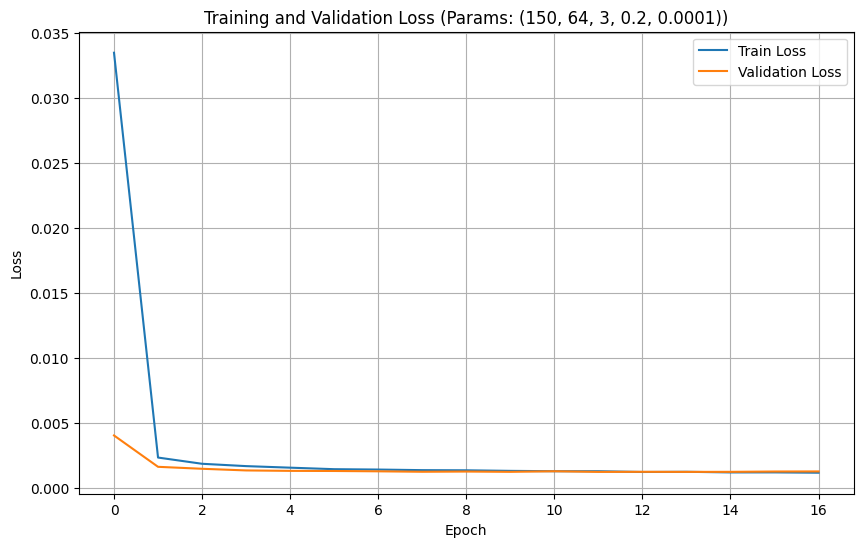

In [ ]:
# Przechowywanie wyników
results = []
best_val_loss = float('inf')
best_model = None
best_params = None
best_test_loader = None

# Iteracja przez kombinacje parametrów
for idx, params in enumerate(param_combinations):
    print(f"Testowanie kombinacji {idx + 1}/{len(param_combinations)}: {params}")
    trained_model, train_losses, val_losses, val_loss, test_loader = train_and_evaluate(params)

    # Zapis wyników
    results.append({
        'params': params,
        'train_loss': train_losses[-1],
        'val_loss': val_loss
    })

    # Sprawdzenie, czy to najlepszy model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = trained_model
        best_params = params
        best_test_loader = test_loader

    # Wizualizacja strat dla bieżącego modelu
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss (Params: {params})')
    plt.legend()
    plt.grid(True)
    plt.show()

#Zebranie wyników

In [ ]:
# Tworzenie tabeli wyników
table = PrettyTable(['Hidden Size', 'Num Layers', 'Dropout', 'Learning Rate','sequence lengths' , 'Train Loss', 'Val Loss'])
for result in results:
    sequence_length, hidden_size, num_layers, dropout, learning_rate = result['params']
    table.add_row([hidden_size, num_layers, dropout, learning_rate, sequence_lengths, result['train_loss'], result['val_loss']])

print(table)

# Wyświetlenie najlepszych parametrów
print(f"Najlepszy model: {best_params}, Validation Loss: {best_val_loss:.4f}")

+-------------+------------+---------+---------------+------------------+-----------------------+-----------------------+
| Hidden Size | Num Layers | Dropout | Learning Rate | sequence lengths |       Train Loss      |        Val Loss       |
+-------------+------------+---------+---------------+------------------+-----------------------+-----------------------+
|      32     |     1      |   0.1   |     0.001     |  [30, 100, 150]  | 0.0010516740167663702 | 0.0012198377335153054 |
|      32     |     1      |   0.1   |     0.0001    |  [30, 100, 150]  | 0.0011965752909741095 | 0.0013085257596685551 |
|      32     |     1      |   0.2   |     0.001     |  [30, 100, 150]  | 0.0010978277282594072 | 0.0012176107557024807 |
|      32     |     1      |   0.2   |     0.0001    |  [30, 100, 150]  | 0.0011327739569335995 |  0.001333385705947876 |
|      32     |     3      |   0.1   |     0.001     |  [30, 100, 150]  | 0.0010523188895838816 |  0.001201339669933077 |
|      32     |     3   

In [ ]:

data = [
    [32, 1, 0.1, 0.001, 0.0010516740167663702, 0.0012198377335153054],
    [32, 1, 0.1, 0.0001, 0.0011965752909741095, 0.0013085257596685551],
    [32, 1, 0.2, 0.001, 0.0010978277282594072, 0.0012176107557024807],
    [32, 1, 0.2, 0.0001, 0.0011327739569335995, 0.001333385705947876],
    [32, 3, 0.1, 0.001, 0.0010523188895838816, 0.001201339669933077],
    [32, 3, 0.1, 0.0001, 0.0011304457547075505, 0.0012058599313604645],
    [32, 3, 0.2, 0.001, 0.0011487610210033675, 0.0011980300732830074],
    [32, 3, 0.2, 0.0001, 0.0013451095174757703, 0.0012089266383554786],
    [64, 1, 0.1, 0.001, 0.0011435615305961091, 0.0012076029815943912],
    [64, 1, 0.1, 0.0001, 0.0010805665792319023, 0.0012065243536198977],
    [64, 1, 0.2, 0.001, 0.0011040546368965279, 0.0013855437864549458],
    [64, 1, 0.2, 0.0001, 0.001088622473968914, 0.0012313631232245825],
    [64, 3, 0.1, 0.001, 0.0010961773692660273, 0.0012019134082947858],
    [64, 3, 0.1, 0.0001, 0.0011036779136291794, 0.0012349930184427649],
    [64, 3, 0.2, 0.001, 0.0010627846030758755, 0.0012218638948979788],
    [64, 3, 0.2, 0.0001, 0.0011216778090505203, 0.0011866022505273577],
    [32, 1, 0.1, 0.001, 0.0010694661032175645, 0.0010590178426355124],
    [32, 1, 0.1, 0.0001, 0.001137710481028383, 0.0011335741562236632],
    [32, 1, 0.2, 0.001, 0.0011030632735734495, 0.0010750737980872924],
    [32, 1, 0.2, 0.0001, 0.0011292651596401507, 0.0011081350468365209],
    [32, 3, 0.1, 0.001, 0.0010724749435515454, 0.0010788383037184498],
    [32, 3, 0.1, 0.0001, 0.0011553548761488249, 0.0010768342846339302],
    [32, 3, 0.2, 0.001, 0.0010859066736884416, 0.00104413613527348],
    [32, 3, 0.2, 0.0001, 0.001204954854135091, 0.0010520716272627137],
    [64, 1, 0.1, 0.001, 0.0010797620139783247, 0.0010657224712693797],
    [64, 1, 0.1, 0.0001, 0.0010933967782572533, 0.001074438266056989],
    [64, 1, 0.2, 0.001, 0.001063149338006042, 0.0010546462726779282],
    [64, 1, 0.2, 0.0001, 0.0011401601824521399, 0.0011513715851054127],
    [64, 3, 0.1, 0.001, 0.001088168202356125, 0.0010647159527122443],
    [64, 3, 0.1, 0.0001, 0.0011093050348184382, 0.0010420941523209745],
    [64, 3, 0.2, 0.001, 0.0011129307744946952, 0.0010804148291104607],
    [64, 3, 0.2, 0.0001, 0.00114660159451887, 0.0010737462892263596],
    [32, 1, 0.1, 0.001, 0.0010935947585191267, 0.0013565993479763467],
    [32, 1, 0.1, 0.0001, 0.00108862285608969, 0.001268147238685439],
    [32, 1, 0.2, 0.001, 0.0010726078529842199, 0.0012907622537265222],
    [32, 1, 0.2, 0.0001, 0.0011959719049627893, 0.0013798711394580703],
    [32, 3, 0.1, 0.001, 0.0010875346468916783, 0.001247769978363067],
    [32, 3, 0.1, 0.0001, 0.0011696382745867596, 0.0012384862541997184],
    [32, 3, 0.2, 0.001, 0.001135782844115359, 0.001344499799112479],
    [32, 3, 0.2, 0.0001, 0.001135755458381027, 0.0012482904712669551],
    [64, 1, 0.1, 0.001, 0.0011071669791514675, 0.0012721808452624828],
    [64, 1, 0.1, 0.0001, 0.0011270106183170962, 0.0012852192448917776],
    [64, 1, 0.2, 0.001, 0.001113848674382704, 0.0013332130620256066],
    [64, 1, 0.2, 0.0001, 0.0011038676001286754, 0.0012559484651622672],
    [64, 3, 0.1, 0.001, 0.0010757710508187302, 0.0012869538137844454]


]




# Tworzenie DataFrame
columns = ['Hidden Size', 'Num Layers', 'Dropout', 'Learning Rate', 'Train Loss', 'Val Loss']
df_results = pd.DataFrame(data, columns=columns)

# Dodawanie kolumny Sequence Lengths
sequence_length_values = np.repeat([30, 100, 150], len(data) // 3)
df_results.insert(4, 'Sequence Lengths', sequence_length_values)

# Wyświetlenie DataFrame z nową kolumną
print(df_results)

    Hidden Size  Num Layers  Dropout  Learning Rate  Sequence Lengths  \
0            32           1      0.1         0.0010                30   
1            32           1      0.1         0.0001                30   
2            32           1      0.2         0.0010                30   
3            32           1      0.2         0.0001                30   
4            32           3      0.1         0.0010                30   
5            32           3      0.1         0.0001                30   
6            32           3      0.2         0.0010                30   
7            32           3      0.2         0.0001                30   
8            64           1      0.1         0.0010                30   
9            64           1      0.1         0.0001                30   
10           64           1      0.2         0.0010                30   
11           64           1      0.2         0.0001                30   
12           64           3      0.1         0.0010

<ipython-input-23-ac84ad7ca49a>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_results, x=param, y='Train Loss', palette='Set2')


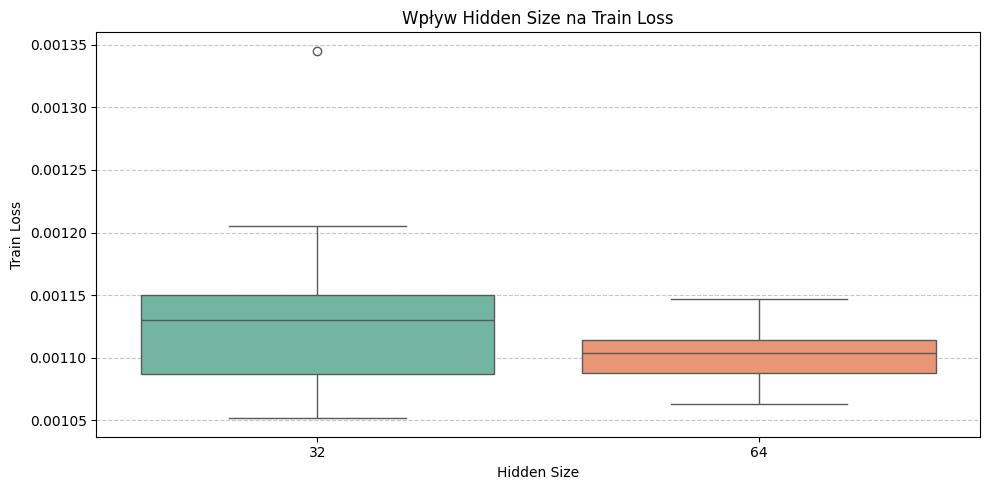

<ipython-input-23-ac84ad7ca49a>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_results, x=param, y='Val Loss', palette='Set3')


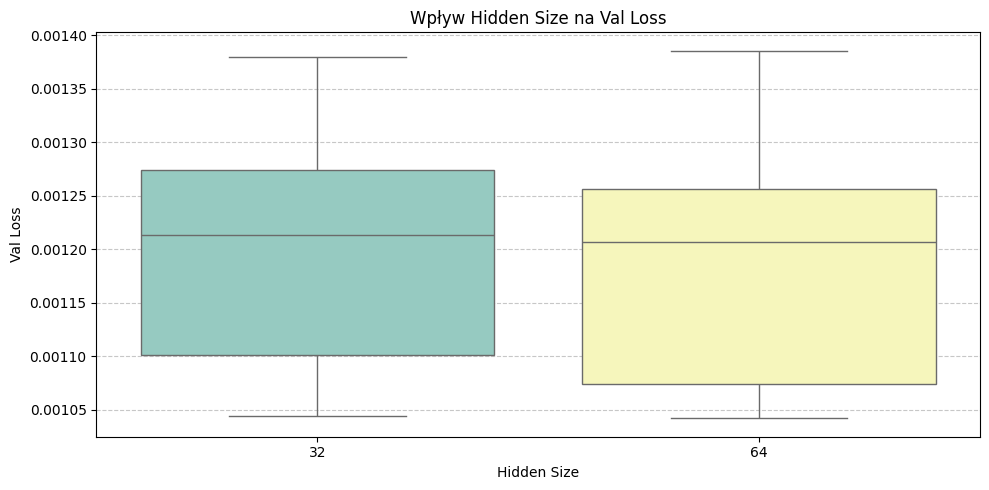

<ipython-input-23-ac84ad7ca49a>:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  min_values_summary = pd.concat([min_values_summary, summary], ignore_index=True)
<ipython-input-23-ac84ad7ca49a>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_results, x=param, y='Train Loss', palette='Set2')


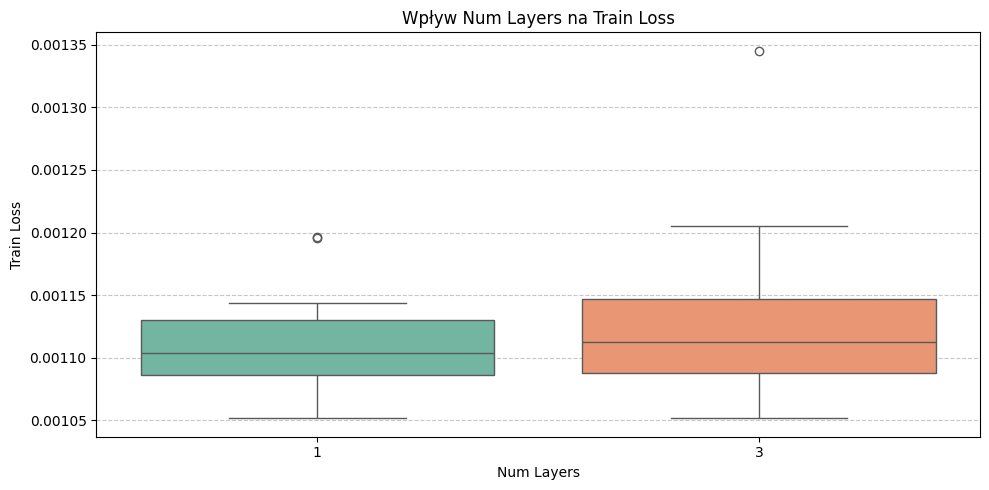

<ipython-input-23-ac84ad7ca49a>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_results, x=param, y='Val Loss', palette='Set3')


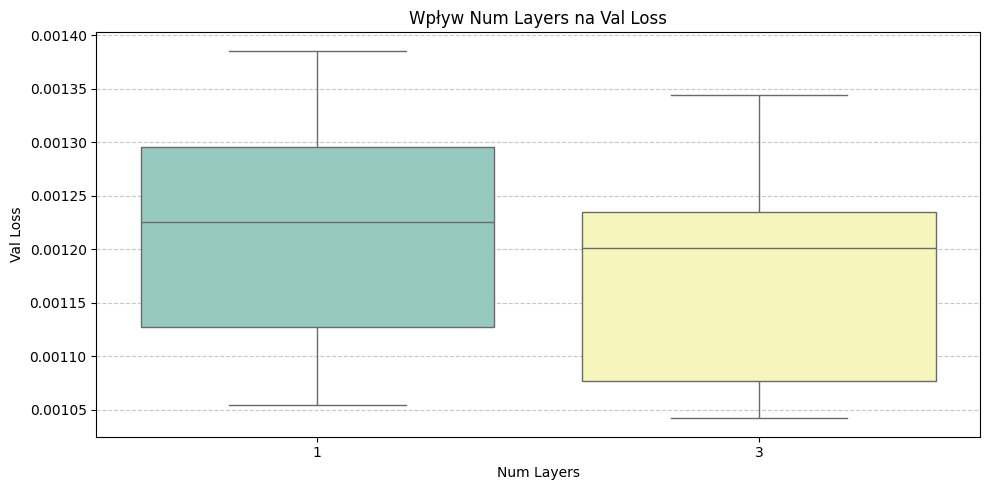

<ipython-input-23-ac84ad7ca49a>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_results, x=param, y='Train Loss', palette='Set2')


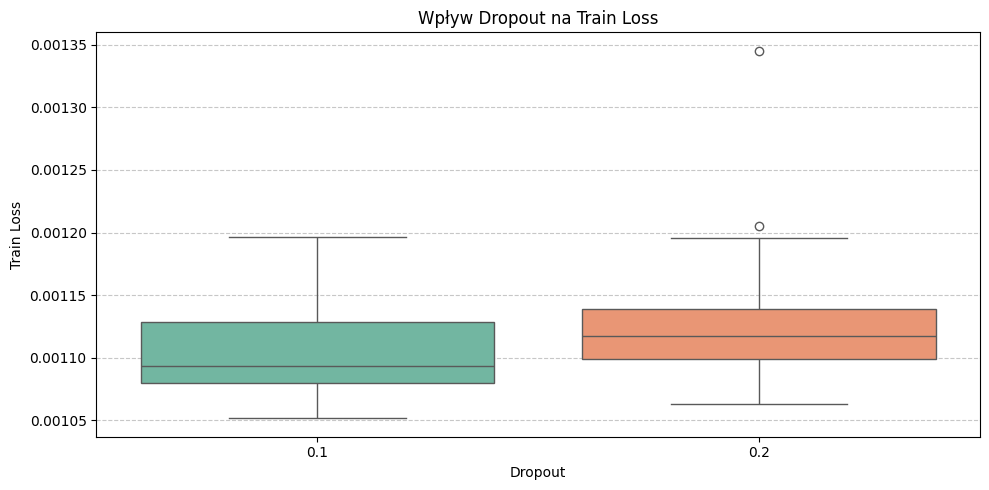

<ipython-input-23-ac84ad7ca49a>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_results, x=param, y='Val Loss', palette='Set3')


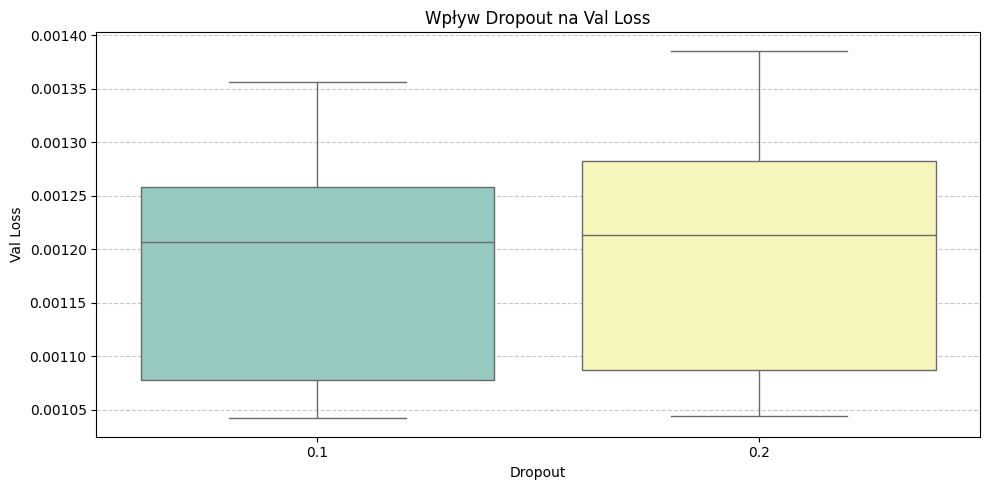

<ipython-input-23-ac84ad7ca49a>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_results, x=param, y='Train Loss', palette='Set2')


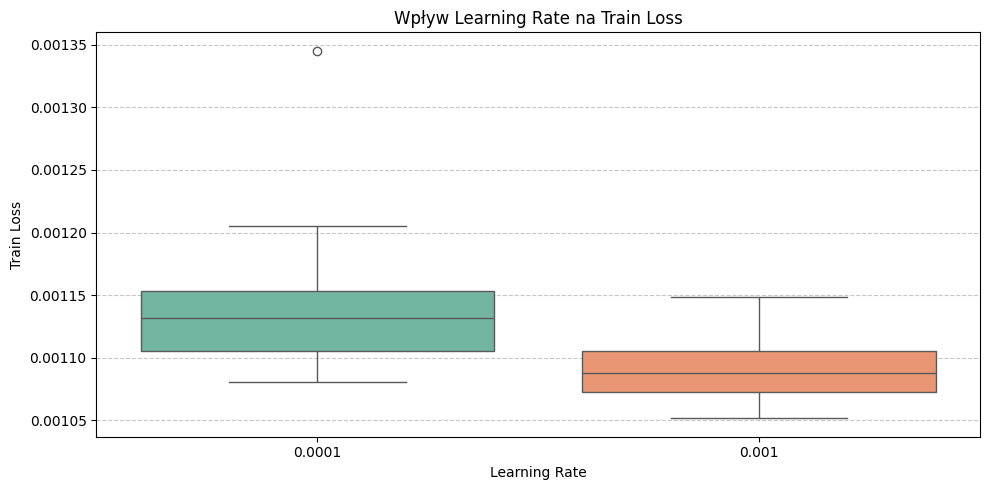

<ipython-input-23-ac84ad7ca49a>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_results, x=param, y='Val Loss', palette='Set3')


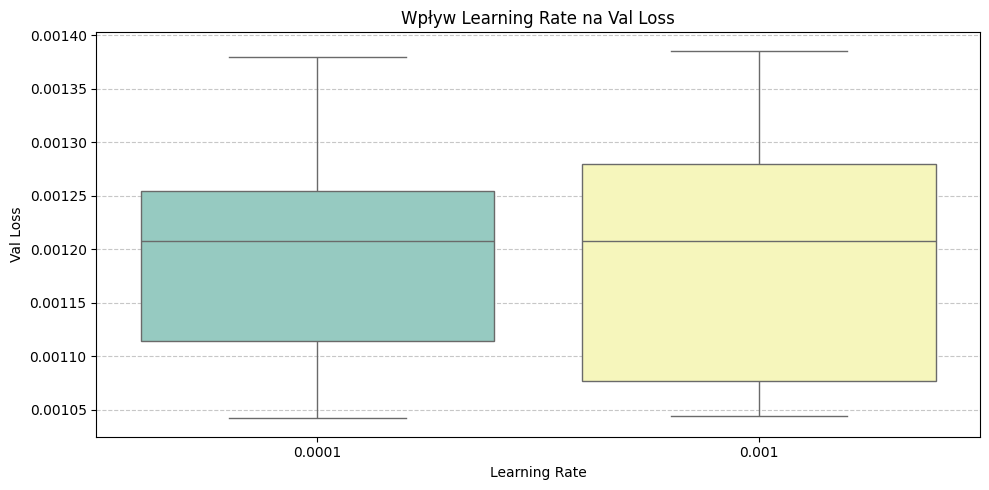

<ipython-input-23-ac84ad7ca49a>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_results, x=param, y='Train Loss', palette='Set2')


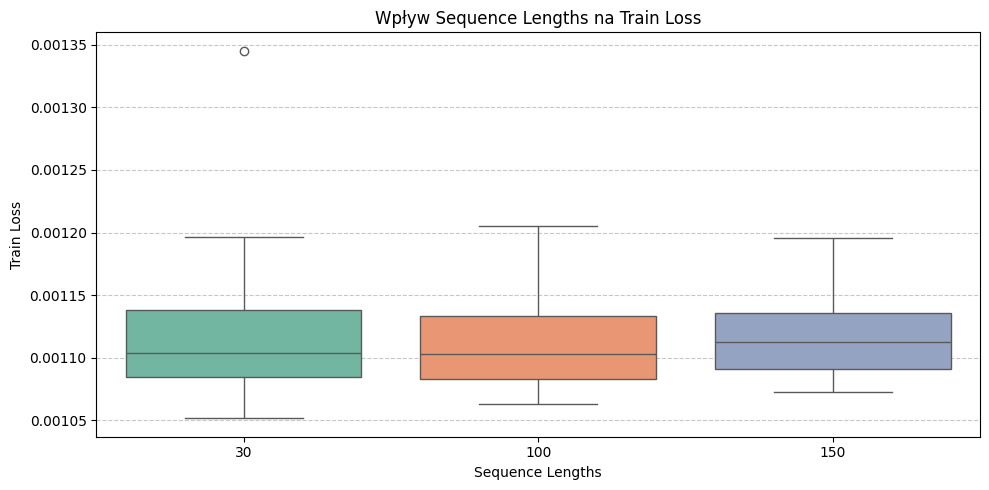

<ipython-input-23-ac84ad7ca49a>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_results, x=param, y='Val Loss', palette='Set3')


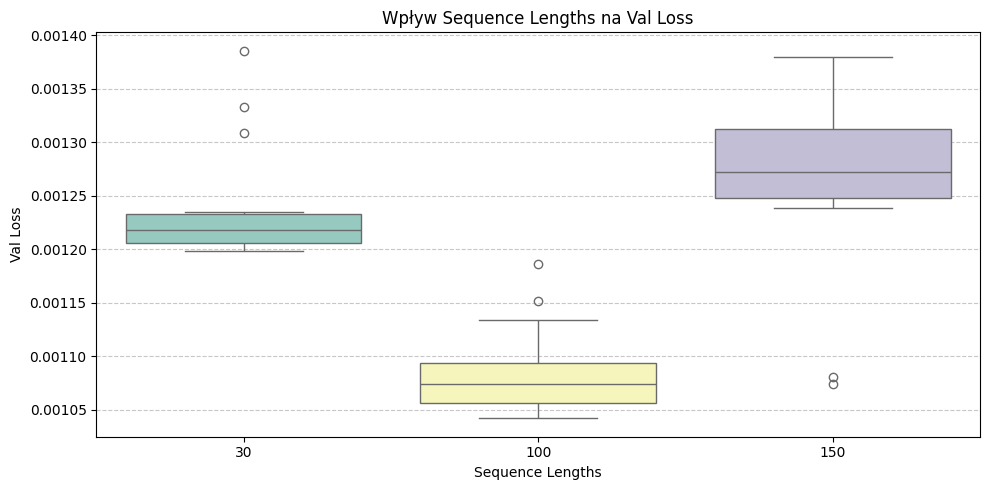

Korelacje między parametrami a wynikami:
                  Train Loss  Val Loss
Val Loss            0.110057  1.000000
Train Loss          1.000000  0.110057
Dropout             0.244401  0.073481
Sequence Lengths   -0.045607  0.026909
Learning Rate      -0.502469  0.001768
Hidden Size        -0.257423 -0.086160
Num Layers          0.167239 -0.253039

Podsumowanie minimalnych wartości dla każdego parametru:
           Parameter   Value  Min Train Loss  Min Val Loss
0        Hidden Size      32        0.001052      0.001044
1        Hidden Size      64        0.001063      0.001042
2         Num Layers       1        0.001052      0.001055
3         Num Layers       3        0.001052      0.001042
4            Dropout     0.1        0.001052      0.001042
5            Dropout     0.2        0.001063      0.001044
6      Learning Rate  0.0001        0.001081      0.001042
7      Learning Rate   0.001        0.001052      0.001044
8   Sequence Lengths      30        0.001052      0.001198

,Parameter,Value,Min Train Loss,Min Val Loss
0,Hidden Size,32,0.001052,0.001044
1,Hidden Size,64,0.001063,0.001042
2,Num Layers,1,0.001052,0.001055
3,Num Layers,3,0.001052,0.001042
4,Dropout,0.1,0.001052,0.001042
5,Dropout,0.2,0.001063,0.001044
6,Learning Rate,0.0001,0.001081,0.001042
7,Learning Rate,0.001,0.001052,0.001044
8,Sequence Lengths,30,0.001052,0.001198
9,Sequence Lengths,100,0.001063,0.001042


In [ ]:
def analyze_results(df_results):
    # Lista parametrów do analizy
    parameters = ['Hidden Size', 'Num Layers', 'Dropout', 'Learning Rate', 'Sequence Lengths']

    # DataFrame do przechowywania minimalnych wartości
    min_values_summary = pd.DataFrame(columns=['Parameter', 'Value', 'Min Train Loss', 'Min Val Loss'])

    for param in parameters:
        # Wykres wpływu parametru na Train Loss
        plt.figure(figsize=(10, 5))
        sns.boxplot(data=df_results, x=param, y='Train Loss', palette='Set2')
        plt.title(f'Wpływ {param} na Train Loss')
        plt.xlabel(param)
        plt.ylabel('Train Loss')
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        # Wykres wpływu parametru na Val Loss
        plt.figure(figsize=(10, 5))
        sns.boxplot(data=df_results, x=param, y='Val Loss', palette='Set3')
        plt.title(f'Wpływ {param} na Val Loss')
        plt.xlabel(param)
        plt.ylabel('Val Loss')
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        # Minimalne wartości dla Train Loss i Val Loss
        min_train_loss = df_results.groupby(param)['Train Loss'].min()
        min_val_loss = df_results.groupby(param)['Val Loss'].min()

        # Dodanie do tabeli podsumowania
        summary = pd.DataFrame({
            'Parameter': param,
            'Value': min_train_loss.index,
            'Min Train Loss': min_train_loss.values,
            'Min Val Loss': min_val_loss.values
        })

        # Dodanie danych do tabeli podsumowania za pomocą pd.concat
        min_values_summary = pd.concat([min_values_summary, summary], ignore_index=True)

    # Korelacje między parametrami a wynikami
    correlation = df_results.corr()
    print("Korelacje między parametrami a wynikami:")
    print(correlation[['Train Loss', 'Val Loss']].sort_values(by='Val Loss', ascending=False))

    # Wyświetlenie tabeli minimalnych wartości
    print("\nPodsumowanie minimalnych wartości dla każdego parametru:")
    print(min_values_summary)
    return min_values_summary

# Uruchomienie analizy
analyze_results(df_results)

Funkcja `evaluate_and_visualize` przeprowadza ocenę modelu na danych testowych oraz wizualizuje wyniki:

1. Ewaluacja modelu:
   - Model jest używany do przewidywania wartości na zbiorze testowym, a rzeczywiste wartości są zbierane do porównania.

2. Odwrócenie skalowania:
   - Przewidywane wartości i rzeczywiste są przywracane do pierwotnej skali za pomocą skalera.

3. Wizualizacja:
   - Tworzony jest wykres porównujący wartości rzeczywiste i przewidywane, co pozwala ocenić, jak dobrze model dopasowuje się do danych.

4. Wyliczenie metryk:
   - Obliczane są statystyki oceny modelu:
     - MAE (Mean Absolute Error): Średni błąd absolutny,
     - MSE (Mean Squared Error): Średni błąd kwadratowy,
     - RMSE (Root Mean Squared Error): Pierwiastek z MSE,
     - R² (R-squared): Współczynnik determinacji.

Funkcja zwraca przewidywane i rzeczywiste wartości, które mogą być wykorzystane do dalszej analizy.

Ewaluacja najlepszego modelu na danych testowych (Parametry: (100, 64, 3, 0.1, 0.0001)):


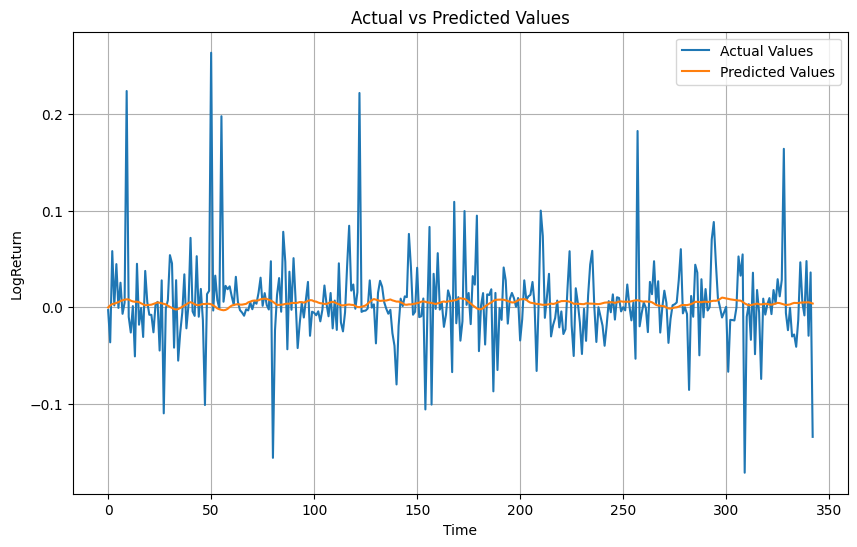

Mean Absolute Error (MAE): 0.0275
Mean Squared Error (MSE): 0.0020
Root Mean Squared Error (RMSE): 0.0448
R² Score: -0.0113


In [ ]:
# Funkcja ewaluacji i wizualizacji
def evaluate_and_visualize(model, test_loader, criterion):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            predictions.append(outputs.numpy())
            actuals.append(y_batch.numpy())

    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)

    # Odskalowanie wartości
    predictions = scaler_y.inverse_transform(predictions)
    actuals = scaler_y.inverse_transform(actuals)

    # Wizualizacja wyników
    plt.figure(figsize=(10, 6))
    plt.plot(actuals, label='Actual Values')
    plt.plot(predictions, label='Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('LogReturn')
    plt.title('Actual vs Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Wyliczenie metryk
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)

    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

    return predictions, actuals

print(f"Ewaluacja najlepszego modelu na danych testowych (Parametry: {best_params}):")
predictions, actuals = evaluate_and_visualize(best_model, test_loader, criterion)